In [1]:
import sys
sys.path.append('../src')

import warnings
# Global suppression
warnings.filterwarnings("ignore", message="Parsing dates in .* when dayfirst=True was specified")
warnings.filterwarnings("ignore", category=FutureWarning)

from preprocessing import *
import tame
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
from config import CONFIG

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader, Subset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _cuda(obj):
    if isinstance(obj, torch.nn.Module):
        return obj.cuda()
    elif isinstance(obj, torch.Tensor):
        return obj.cuda()
    elif isinstance(obj, np.ndarray):
        return torch.from_numpy(obj).cuda()
    
def index_value(data):
    index = data // (CONFIG['split_num'] + 1)
    value = data % (CONFIG['split_num'] + 1)
    index = Variable(_cuda(index))
    value = Variable(_cuda(value))
    return [index, value]

In [2]:
dfs = get_dfs()
biopsy_df = dfs['biopsy'].copy()
static_df= create_static_df(dfs)
vital_df = create_vitals_df(dfs, static_df)
med_df = create_medication_df(dfs, static_df)
lab_df = create_lab_values_df(dfs, static_df)
ts_data = create_ts_df(vital_df, lab_df, med_df, merge_lab=True, merge_med=True)
print(ts_data.columns)

# Create the dataset
full_dataset = NephroDataset(static_df, ts_data, biopsy_df, phase='test')

# Split dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 32
data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

static_scaler = full_dataset.scaler
cat_scaler = full_dataset.label_encoders
categorical_cardinalities = full_dataset.categorical_cardinalities
print(f"Categorical cardinalities: {categorical_cardinalities}")

max rel_days 8034
max number of rows across all patients 1105
Index(['patient_id', 'transplant_id', 'rel_days', 'bp_sys', 'bp_dia', 'weight',
       'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin',
       'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01',
       'L04AD02'],
      dtype='object')
Categorical cardinalities: [438, 9, 3, 3, 9, 10, 2, 3]


In [3]:
checkpoint = torch.load('../model_checkpoints/models/best.ckpt', weights_only=False)
print(checkpoint.keys())
print(checkpoint['epoch'])

model = tame.AutoEncoder(categorical_cardinalities=categorical_cardinalities)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

dict_keys(['epoch', 'best_metric', 'state_dict', 'best r2s'])
33


In [4]:
# load feature_mm file
with open('../feature_mm.json', 'r') as f:
    feature_mm = json.load(f)

print(list(feature_mm.keys()))

# load feature_ms file
with open('../feature_ms.json', 'r') as f:
    feature_ms = json.load(f)
print(list(feature_ms.keys()))

['bp_sys', 'bp_dia', 'weight', 'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin', 'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01', 'L04AD02']
['bp_sys', 'bp_dia', 'weight', 'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin', 'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01', 'L04AD02']


In [5]:
# After loading feature_mm
keys = list(feature_mm.keys())

mins = torch.tensor([feature_mm[keys[i]][0] for i in range(15)], device=device)
maxs = torch.tensor([feature_mm[keys[i]][1] for i in range(15)], device=device)

means = torch.tensor([feature_ms[keys[i]][0] for i in range(15)], device=device)
stds = torch.tensor([feature_ms[keys[i]][1] for i in range(15)], device=device)

In [6]:
def extract_embedding_features(model, data_loader, last_embedding=True):
    model.eval()
    with torch.no_grad():
        all_embeddings = []
        all_num_static = []
        all_cat_static = []
        all_ts_features = []
        real_ts_features = []

        all_patient_ids = []
        graft_loss_labels = []
        death_labels = []
        rej_days = []

        graft_loss_days = []
        mort_days = []
        rel_days_list_out = []

        for batch in tqdm(data_loader):
            # Move inputs to GPU if needed
            ts_data = index_value(batch['input_ts_features'])
            neib = [index_value(batch['pre_input']), Variable(_cuda(batch['pre_time'])), index_value(batch['post_input']), Variable(_cuda(batch['post_time']))]

            static_num = Variable(_cuda(batch['static_numerical_features']))

            static_cat = Variable(_cuda(batch['static_categorical_features']))

            patient_ids_batch = batch['patient_id']

            seq_lens = batch['seq_len']
            output = model(ts_data, neib, static_num, static_cat,  get_embedding=True)

            rej_days_batch = batch['rej_rel_days_list']

            batch_embeddings = []
            for i in range(output.shape[0]):
                seq_len = seq_lens[i].item()
                if last_embedding:
                    rep = output[i, :seq_len, :].cpu().numpy()  # mean embedding over sequence
                    rep = rep[-1, :]
                else:  # mean
                    rep = output[i, :seq_len, :].mean(dim=0).cpu().numpy() # mean embedding
                batch_embeddings.append(rep)

                rej_days_i = np.array(rej_days_batch[i], dtype=np.float32)
                rej_days.append(rej_days_i)

            all_embeddings.append(batch_embeddings)

            pad_mask = Variable(_cuda(batch['mask']))

            real_data = Variable(_cuda(batch['real_ts_data']))
            
            impute_output = model(ts_data, neib, static_num, static_cat, mask=pad_mask)
            output_real = impute_output * (maxs - mins)[None, None, :] + mins[None, None, :]
            batch_size = real_data.size(0)

            loss_days = batch['loss_rel_days']
            death_days = batch['death_rel_days']

            for i in range(batch_size):
                valid_len = seq_lens[i]
                # Extract the valid part (not padded) for this patient
                real_slice = real_data[i, :valid_len, :]
                output_slice = output_real[i, :valid_len, :]

                # Separate rel_days and real features
                rel_days = real_slice[:, 0].unsqueeze(-1)
                real_features = real_slice[:, 1:]

                # Replace NaNs in real features with output prediction
                nan_mask = torch.isnan(real_features)
                real_features[nan_mask] = output_slice[nan_mask]

                means_ = real_features.mean(dim=0)
                stds_ = real_features.std(dim=0)
                last = real_features[-1, :]
                slope = (
                    (real_features[-1, :] - real_features[0, :]) / (rel_days[-1] - rel_days[0])
                    if rel_days.size(0) > 1 else torch.zeros_like(means)
                )
                summary_vector = torch.cat([means_, stds_, last, slope])

                all_ts_features.append(summary_vector.cpu().numpy())

                # z-score normalization
                #real_features = (real_features - means) / stds

                real_ts_features.append(real_features.cpu().numpy())

                loss_day = loss_days[i].item()
                if loss_day is None or np.isnan(loss_day):
                    loss_day = rel_days[-1].cpu().item()

                if death_days[i].item() is None or np.isnan(death_days[i].item()):
                    death_day = rel_days[-1].cpu().item()
                else:
                    death_day = death_days[i].item()

                graft_loss_days.append(loss_day)
                mort_days.append(death_day)
                rel_days_list_out.append(rel_days.squeeze(-1).cpu().numpy())

    
            num_feat_ = static_num.cpu().numpy()
            static_unscaled = static_scaler.inverse_transform(num_feat_)
            all_num_static.append(static_unscaled)

            cat_feat_ = static_cat.cpu().numpy()
            cat_decoded = []
            for i, (col, le) in enumerate(cat_scaler.items()):
                cat_decoded.append(le.inverse_transform(cat_feat_[:, i]))

            all_cat_static.extend(np.array(cat_decoded).T.tolist())

            graft_loss_label = batch['graft_loss_label'].cpu().numpy()
            death_label = batch['death_label'].cpu().numpy()
            graft_loss_labels.append(graft_loss_label)
            death_labels.append(death_label)
            all_patient_ids.append(patient_ids_batch)


        all_embeddings = np.concatenate(all_embeddings, axis=0)
        all_patient_ids = np.concatenate(all_patient_ids, axis=0)
        all_num_static = np.concatenate(all_num_static, axis=0)
        all_cat_static = np.array(all_cat_static)
        graft_loss_labels = np.concatenate(graft_loss_labels, axis=0).squeeze()
        death_labels = np.concatenate(death_labels, axis=0).squeeze()

        return (
            all_embeddings, 
            all_patient_ids, 
            graft_loss_labels, 
            death_labels, 
            all_num_static, 
            all_cat_static, 
            all_ts_features,
            real_ts_features,
            graft_loss_days,
            mort_days,
            rej_days,
            rel_days_list_out)

In [22]:
embeddings, patient_ids, graft_labels, death_label, num_static, cat_static, ts_feats, real_ts_features, graft_loss_days, mort_days, rej_days, rel_days = extract_embedding_features(model, data_loader, last_embedding=False)

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


In [7]:
last_embedding, patient_ids_l, graft_labels_l, death_label_l, num_static_l, cat_static_l, ts_feats_l, real_ts_features_l, graft_loss_days_l, mort_days_l, rej_days_l, rel_days_l = extract_embedding_features(model, data_loader, last_embedding=True)

100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


n_clusters=2, k=5: Silhouette=0.256, Davies-Bouldin=1.431, Calinski-Harabasz=1267.637, Stability (std of silhouette)=0.053
n_clusters=2, k=10: Silhouette=0.259, Davies-Bouldin=1.419, Calinski-Harabasz=1284.253, Stability (std of silhouette)=0.008
n_clusters=2, k=15: Silhouette=0.258, Davies-Bouldin=1.421, Calinski-Harabasz=1274.393, Stability (std of silhouette)=0.007
n_clusters=2, k=20: Silhouette=0.259, Davies-Bouldin=1.420, Calinski-Harabasz=1285.373, Stability (std of silhouette)=0.007
n_clusters=2, k=30: Silhouette=0.259, Davies-Bouldin=1.424, Calinski-Harabasz=1286.889, Stability (std of silhouette)=0.007
n_clusters=2, k=40: Silhouette=0.259, Davies-Bouldin=1.421, Calinski-Harabasz=1287.895, Stability (std of silhouette)=0.007
n_clusters=2, k=45: Silhouette=0.259, Davies-Bouldin=1.421, Calinski-Harabasz=1289.565, Stability (std of silhouette)=0.007
n_clusters=2, k=50: Silhouette=0.259, Davies-Bouldin=1.421, Calinski-Harabasz=1286.875, Stability (std of silhouette)=0.006
n_cluster

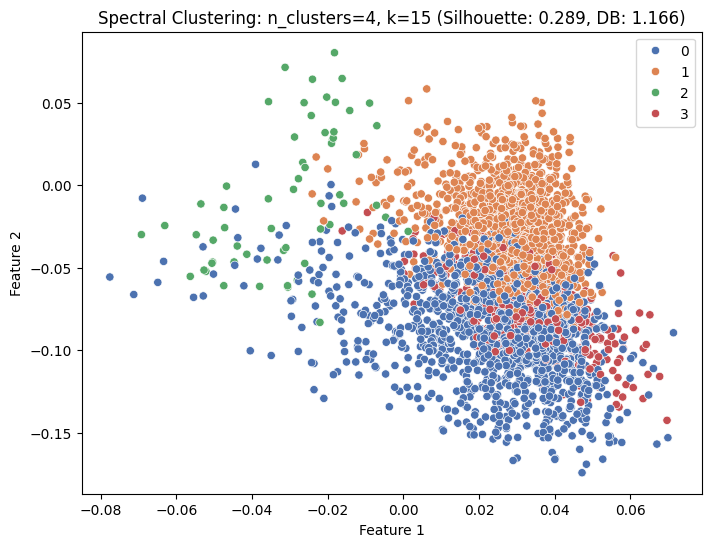

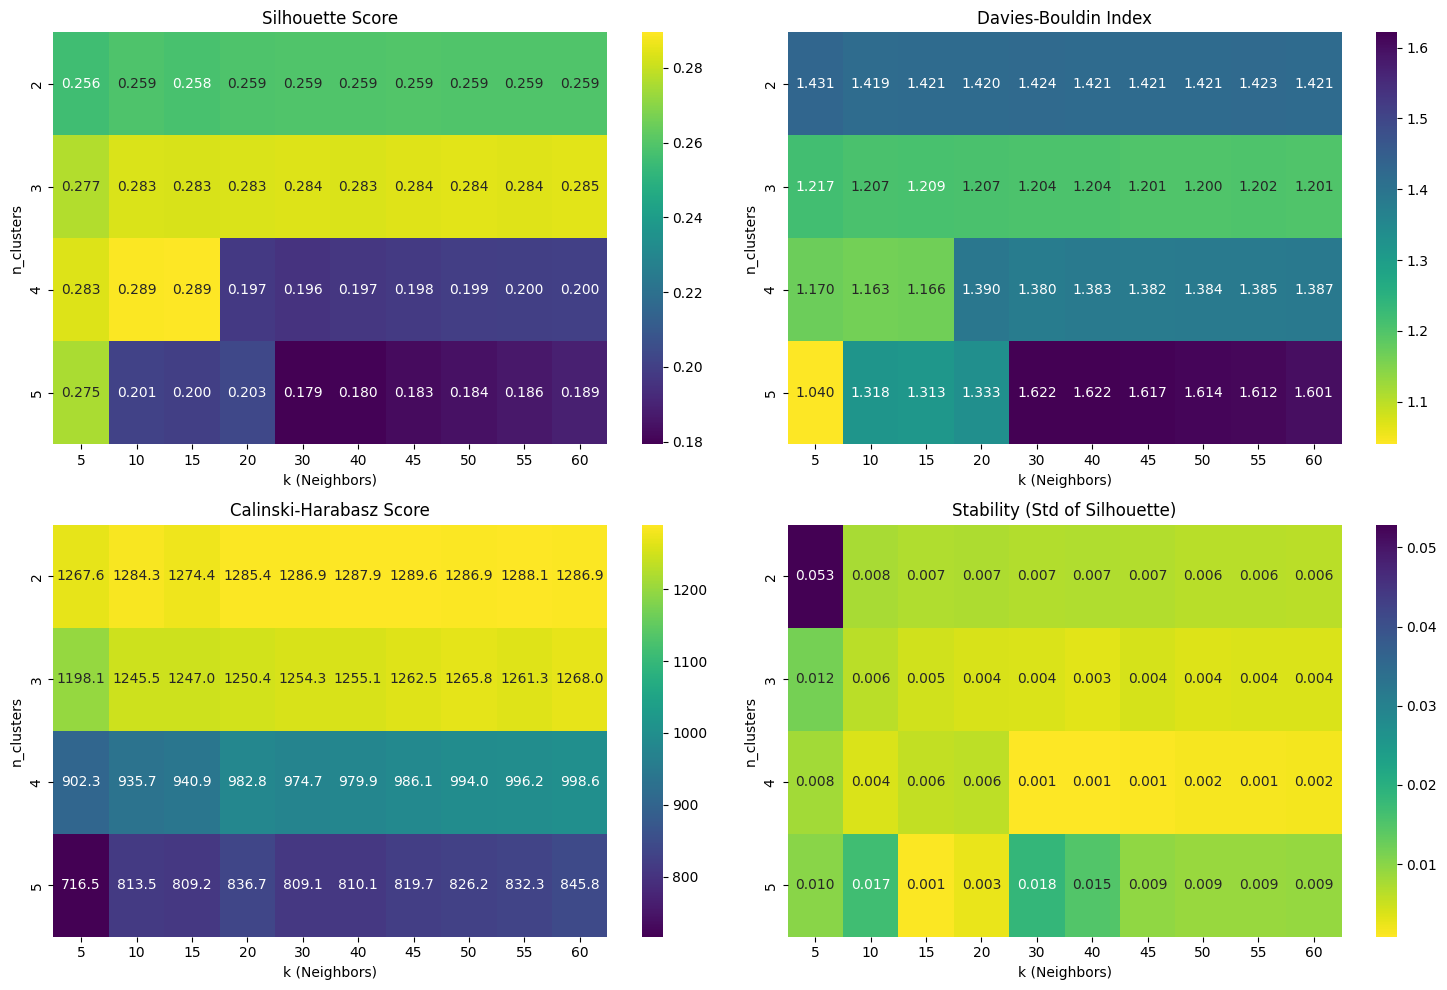

In [ ]:
# Exploring best n_clusters and n_neighbors for mean embedding
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import KFold
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Generate synthetic dataset 
X = embeddings

# Define ranges for k (neighbors) and n_clusters
k_values = [5, 10, 15, 20, 30, 40, 45, 50, 55, 60]
n_clusters_range = [2, 3, 4, 5]

# Initialize lists to store evaluation metrics
results = []

# Perform 3-fold cross-validation for cluster stability
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Evaluate each combination of k and n_clusters
for n_clusters in n_clusters_range:
    for k in k_values:
        # Initialize spectral clustering
        sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', 
                               n_neighbors=k, random_state=42)
        
        # Compute metrics for the full dataset
        labels = sc.fit_predict(X)
        silhouette = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        
        # Cross-validation for cluster stability
        fold_consistency = []
        for train_idx, test_idx in kf.split(X):
            X_train = X[train_idx]
            X_test = X[test_idx]
            sc.fit(X_train)
            test_labels = sc.fit_predict(X_test)
            fold_consistency.append(silhouette_score(X_test, test_labels))
        
        # Compute stability as standard deviation of silhouette scores across folds
        stability = np.std(fold_consistency)
        
        results.append({
            'n_clusters': n_clusters,
            'k': k,
            'silhouette': silhouette,
            'db': db,
            'ch': ch,
            'stability': stability
        })
        
        print(f"n_clusters={n_clusters}, k={k}: Silhouette={silhouette:.3f}, "
              f"Davies-Bouldin={db:.3f}, Calinski-Harabasz={ch:.3f}, "
              f"Stability (std of silhouette)={stability:.3f}")

# Filter results where DB <= 0.7
filtered_results = [r for r in results if r['db'] <= 0.7]

# Find best combination based on silhouette score among filtered results
if filtered_results:
    best_result = max(filtered_results, key=lambda x: x['silhouette'])
    best_n_clusters = best_result['n_clusters']
    best_k = best_result['k']
    print(f"\nBest combination (DB <= 0.7, max silhouette): n_clusters={best_n_clusters}, "
          f"k={best_k} (Silhouette: {best_result['silhouette']:.3f}, DB: {best_result['db']:.3f})")
else:
    print("\nNo combinations found with DB <= 0.7. Consider relaxing the constraint or adjusting k/n_clusters ranges.")
    # Fallback to best silhouette score overall
    best_result = max(results, key=lambda x: x['silhouette'])
    best_n_clusters = best_result['n_clusters']
    best_k = best_result['k']
    print(f"Fallback best combination (max silhouette): n_clusters={best_n_clusters}, "
          f"k={best_k} (Silhouette: {best_result['silhouette']:.3f}, DB: {best_result['db']:.3f})")

# Visualize clustering results for the best combination
sc_best = SpectralClustering(n_clusters=best_n_clusters, affinity='nearest_neighbors', 
                            n_neighbors=best_k, random_state=42)
labels_best = sc_best.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_best, palette='deep')
plt.title(f'Spectral Clustering: n_clusters={best_n_clusters}, k={best_k} '
          f'(Silhouette: {best_result["silhouette"]:.3f}, DB: {best_result["db"]:.3f})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot evaluation metrics as heatmaps
silhouette_matrix = pd.DataFrame(
    [[r['silhouette'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)
db_matrix = pd.DataFrame(
    [[r['db'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)
ch_matrix = pd.DataFrame(
    [[r['ch'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)
stability_matrix = pd.DataFrame(
    [[r['stability'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.heatmap(silhouette_matrix, annot=True, fmt='.3f', cmap='viridis')
plt.title('Silhouette Score')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')

plt.subplot(2, 2, 2)
sns.heatmap(db_matrix, annot=True, fmt='.3f', cmap='viridis_r')
plt.title('Davies-Bouldin Index')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')

plt.subplot(2, 2, 3)
sns.heatmap(ch_matrix, annot=True, fmt='.1f', cmap='viridis')
plt.title('Calinski-Harabasz Score')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')

plt.subplot(2, 2, 4)
sns.heatmap(stability_matrix, annot=True, fmt='.3f', cmap='viridis_r')
plt.title('Stability (Std of Silhouette)')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')
plt.tight_layout()
plt.show()

n_clusters=2, k=5: Silhouette=0.470, Davies-Bouldin=1.077, Calinski-Harabasz=2260.276, Stability (std of silhouette)=0.113
n_clusters=2, k=10: Silhouette=0.470, Davies-Bouldin=1.077, Calinski-Harabasz=2260.276, Stability (std of silhouette)=0.012
n_clusters=2, k=15: Silhouette=0.470, Davies-Bouldin=1.077, Calinski-Harabasz=2260.276, Stability (std of silhouette)=0.001
n_clusters=2, k=20: Silhouette=0.474, Davies-Bouldin=1.068, Calinski-Harabasz=2285.420, Stability (std of silhouette)=0.001
n_clusters=2, k=30: Silhouette=0.498, Davies-Bouldin=1.011, Calinski-Harabasz=2449.342, Stability (std of silhouette)=0.002
n_clusters=2, k=40: Silhouette=0.498, Davies-Bouldin=1.011, Calinski-Harabasz=2449.342, Stability (std of silhouette)=0.002
n_clusters=2, k=45: Silhouette=0.498, Davies-Bouldin=1.011, Calinski-Harabasz=2449.342, Stability (std of silhouette)=0.002
n_clusters=2, k=50: Silhouette=0.498, Davies-Bouldin=1.011, Calinski-Harabasz=2449.342, Stability (std of silhouette)=0.002
n_cluster

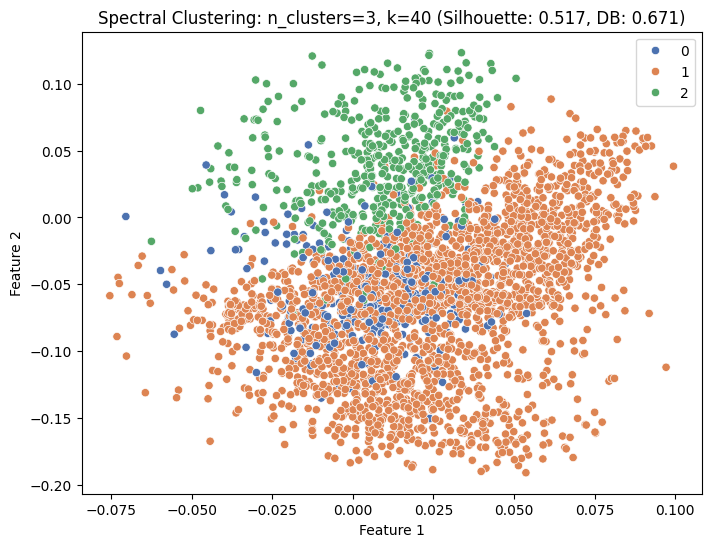

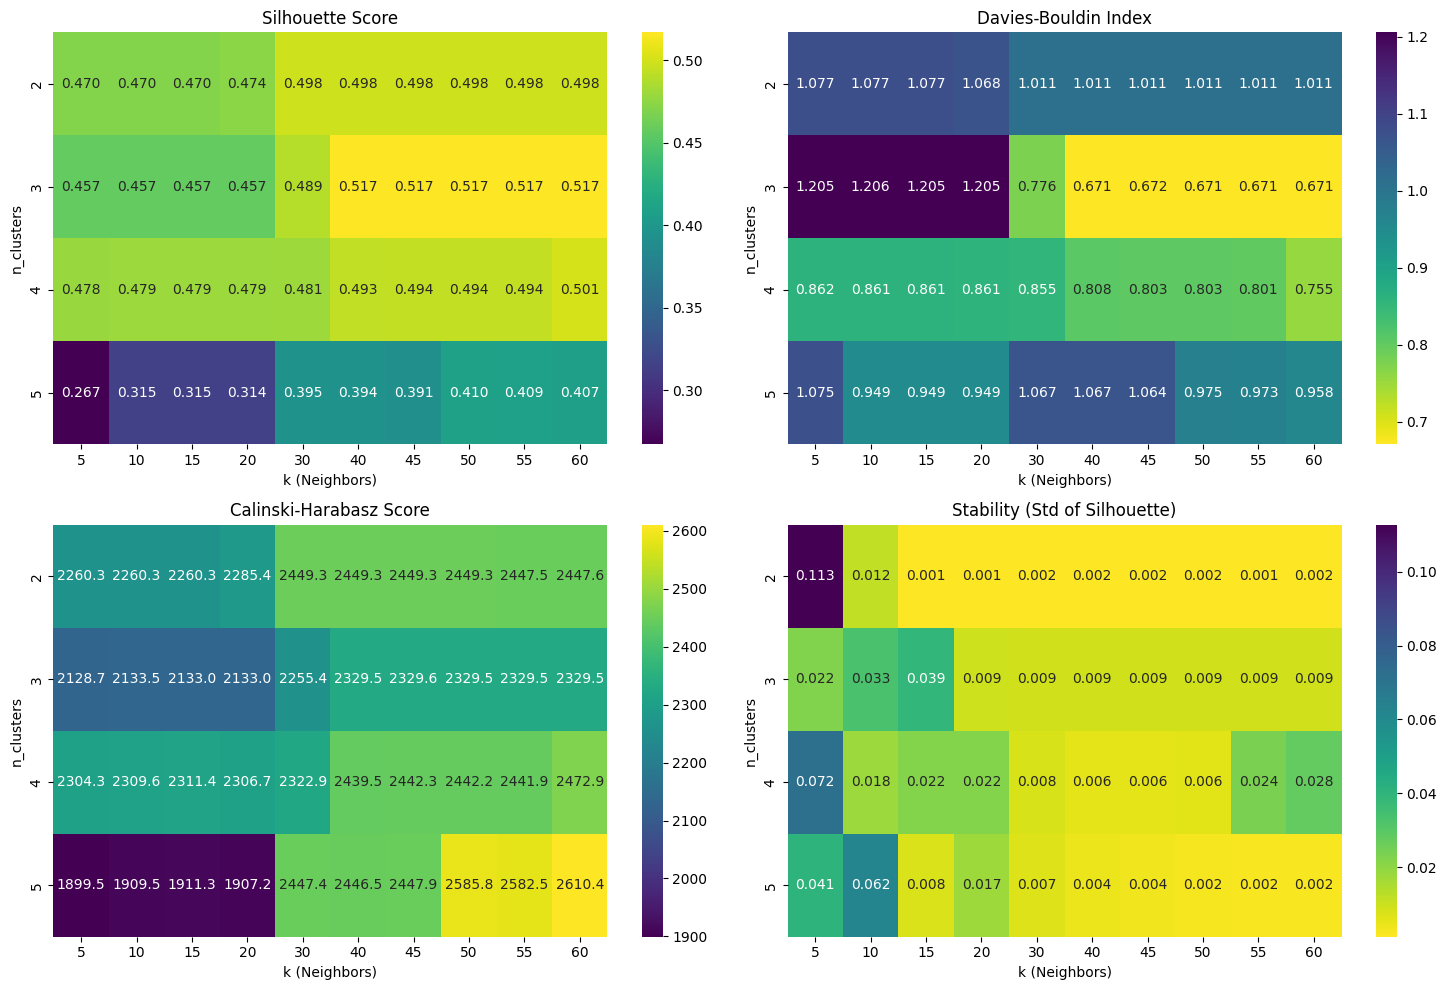

In [ ]:
# Exploring best n_clusters and n_neighbors for last embedding
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import KFold
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Generate synthetic dataset 
X = last_embedding

# Define ranges for k (neighbors) and n_clusters
k_values = [5, 10, 15, 20, 30, 40, 45, 50, 55, 60]
n_clusters_range = [2, 3, 4, 5]

# Initialize lists to store evaluation metrics
results = []

# Perform 3-fold cross-validation for cluster stability
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Evaluate each combination of k and n_clusters
for n_clusters in n_clusters_range:
    for k in k_values:
        # Initialize spectral clustering
        sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', 
                               n_neighbors=k, random_state=42)
        
        # Compute metrics for the full dataset
        labels = sc.fit_predict(X)
        silhouette = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        
        # Cross-validation for cluster stability
        fold_consistency = []
        for train_idx, test_idx in kf.split(X):
            X_train = X[train_idx]
            X_test = X[test_idx]
            sc.fit(X_train)
            test_labels = sc.fit_predict(X_test)
            fold_consistency.append(silhouette_score(X_test, test_labels))
        
        # Compute stability as standard deviation of silhouette scores across folds
        stability = np.std(fold_consistency)
        
        results.append({
            'n_clusters': n_clusters,
            'k': k,
            'silhouette': silhouette,
            'db': db,
            'ch': ch,
            'stability': stability
        })
        
        print(f"n_clusters={n_clusters}, k={k}: Silhouette={silhouette:.3f}, "
              f"Davies-Bouldin={db:.3f}, Calinski-Harabasz={ch:.3f}, "
              f"Stability (std of silhouette)={stability:.3f}")

# Filter results where DB <= 0.7
filtered_results = [r for r in results if r['db'] <= 0.7]

# Find best combination based on silhouette score among filtered results
if filtered_results:
    best_result = max(filtered_results, key=lambda x: x['silhouette'])
    best_n_clusters = best_result['n_clusters']
    best_k = best_result['k']
    print(f"\nBest combination (DB <= 0.7, max silhouette): n_clusters={best_n_clusters}, "
          f"k={best_k} (Silhouette: {best_result['silhouette']:.3f}, DB: {best_result['db']:.3f})")
else:
    print("\nNo combinations found with DB <= 0.7. Consider relaxing the constraint or adjusting k/n_clusters ranges.")
    # Fallback to best silhouette score overall
    best_result = max(results, key=lambda x: x['silhouette'])
    best_n_clusters = best_result['n_clusters']
    best_k = best_result['k']
    print(f"Fallback best combination (max silhouette): n_clusters={best_n_clusters}, "
          f"k={best_k} (Silhouette: {best_result['silhouette']:.3f}, DB: {best_result['db']:.3f})")

# Visualize clustering results for the best combination
sc_best = SpectralClustering(n_clusters=best_n_clusters, affinity='nearest_neighbors', 
                            n_neighbors=best_k, random_state=42)
labels_best = sc_best.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_best, palette='deep')
plt.title(f'Spectral Clustering: n_clusters={best_n_clusters}, k={best_k} '
          f'(Silhouette: {best_result["silhouette"]:.3f}, DB: {best_result["db"]:.3f})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot evaluation metrics as heatmaps
silhouette_matrix = pd.DataFrame(
    [[r['silhouette'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)
db_matrix = pd.DataFrame(
    [[r['db'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)
ch_matrix = pd.DataFrame(
    [[r['ch'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)
stability_matrix = pd.DataFrame(
    [[r['stability'] for r in results if r['n_clusters'] == n] for n in n_clusters_range],
    index=n_clusters_range, columns=k_values
)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.heatmap(silhouette_matrix, annot=True, fmt='.3f', cmap='viridis')
plt.title('Silhouette Score')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')

plt.subplot(2, 2, 2)
sns.heatmap(db_matrix, annot=True, fmt='.3f', cmap='viridis_r')
plt.title('Davies-Bouldin Index')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')

plt.subplot(2, 2, 3)
sns.heatmap(ch_matrix, annot=True, fmt='.1f', cmap='viridis')
plt.title('Calinski-Harabasz Score')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')

plt.subplot(2, 2, 4)
sns.heatmap(stability_matrix, annot=True, fmt='.3f', cmap='viridis_r')
plt.title('Stability (Std of Silhouette)')
plt.xlabel('k (Neighbors)')
plt.ylabel('n_clusters')
plt.tight_layout()
plt.show()

Silhouette Score:        0.52
Calinski-Harabasz Score: 2326.04
Davies-Bouldin Score:    0.67
Interactive 3D plot with togglable clusters saved as ../plots/clustering_last_embedding.html


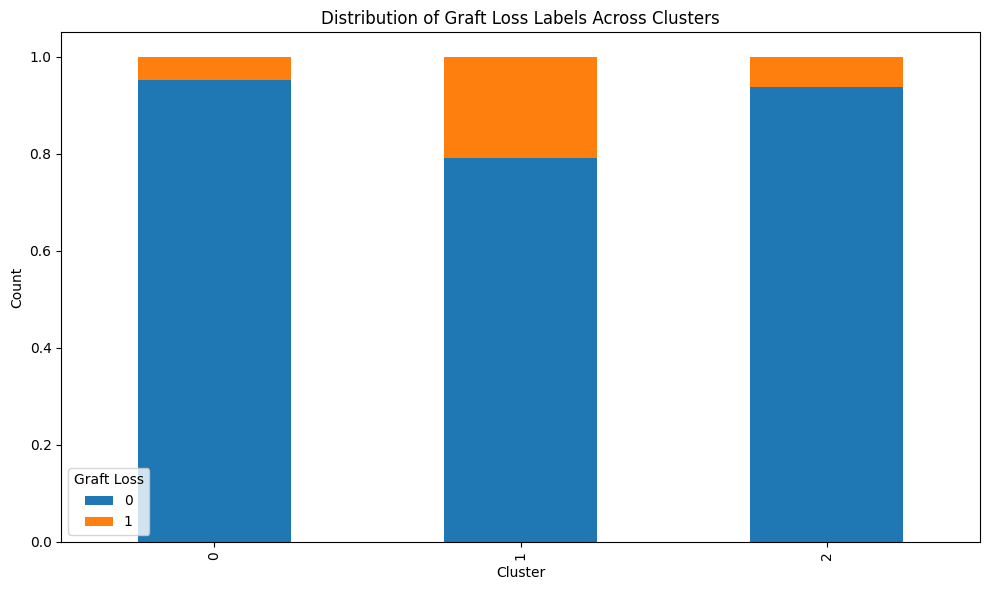

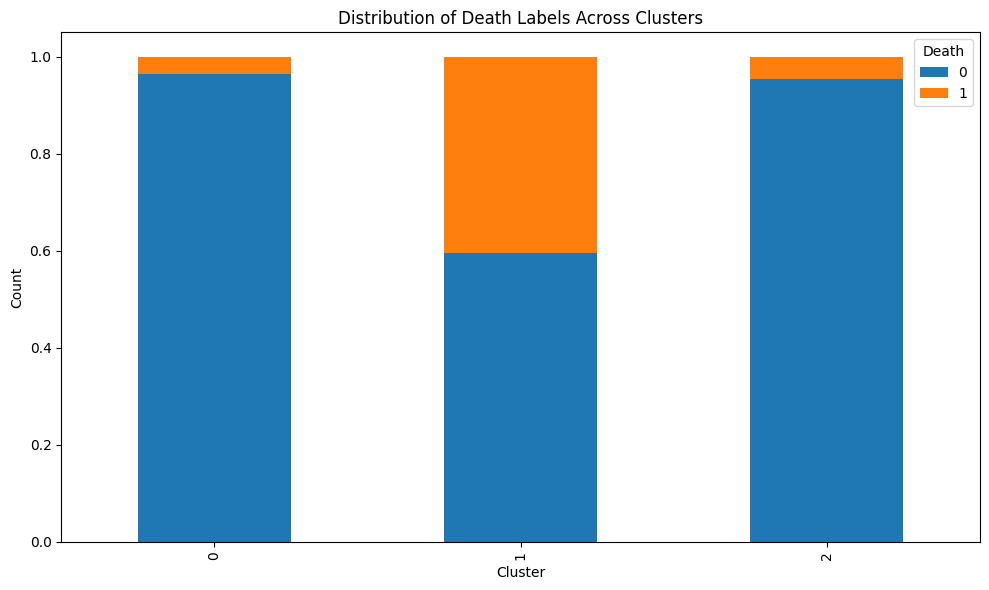

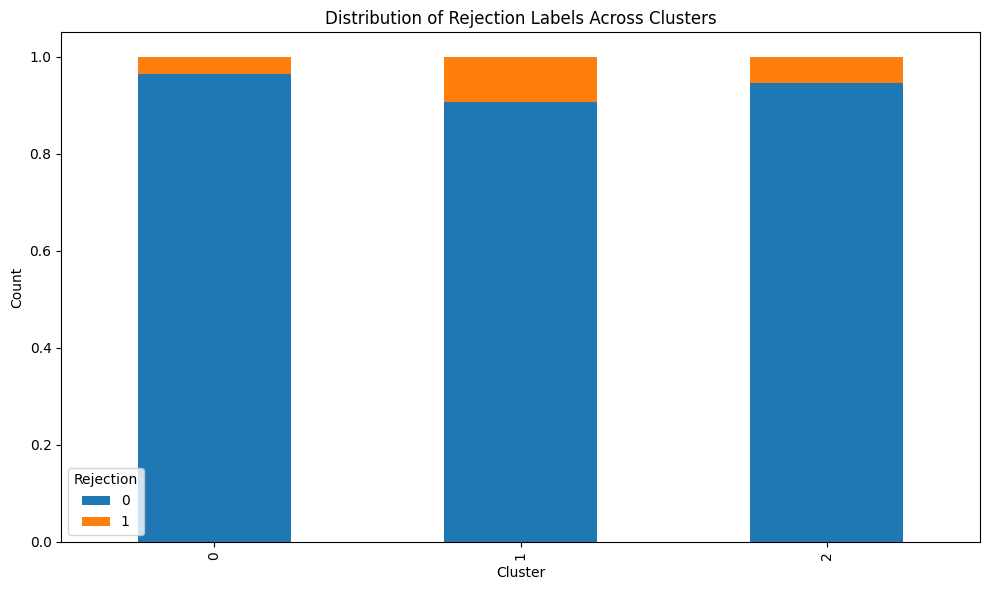

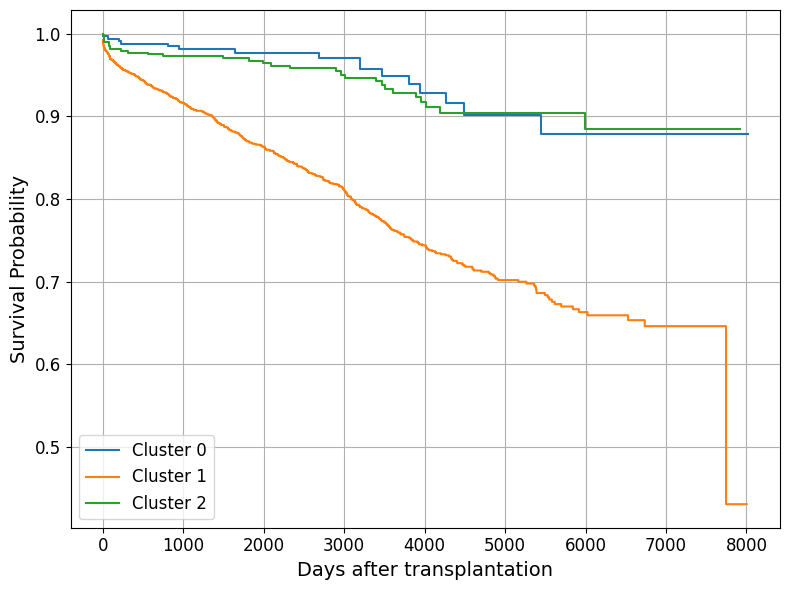

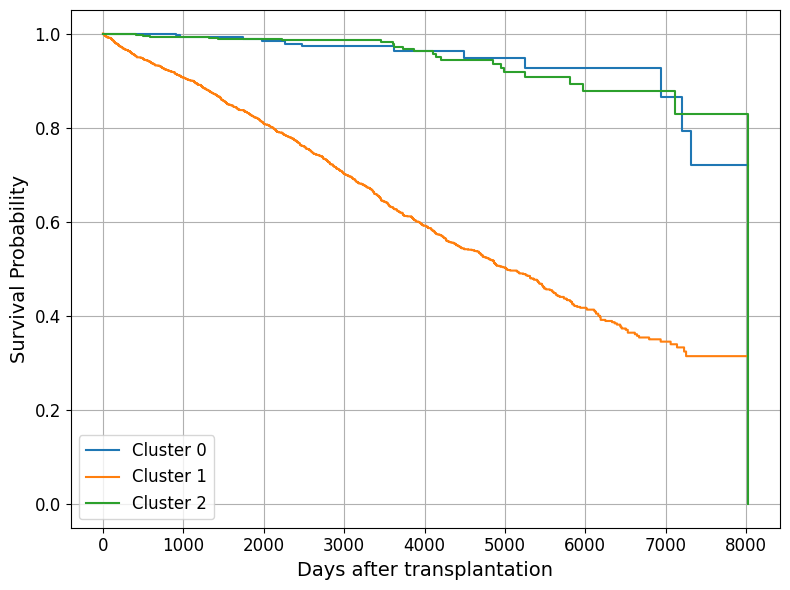

In [8]:
# apply spectral clustering on last embedding 
import numpy as np
import plotly.graph_objects as go
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import datetime
from lifelines import KaplanMeierFitter

# Assume embeddings is a 2D numpy array
embeddings_2d = last_embedding

# Spectral Clustering
spectral_clusterer = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=55, random_state=42)
spectral_labels = spectral_clusterer.fit_predict(embeddings_2d)

# Clustering metrics
print(f'Silhouette Score:        {silhouette_score(embeddings_2d, spectral_labels):.2f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_score(embeddings_2d, spectral_labels):.2f}')
print(f'Davies-Bouldin Score:    {davies_bouldin_score(embeddings_2d, spectral_labels):.2f}')

# PCA to 3D
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings_2d)

# Create separate traces per cluster
fig = go.Figure()
n_clusters = len(np.unique(spectral_labels))

for cluster_id in range(n_clusters):
    idx = np.where(spectral_labels == cluster_id)[0]
    fig.add_trace(go.Scatter3d(
        x=embeddings_3d[idx, 0],
        y=embeddings_3d[idx, 1],
        z=embeddings_3d[idx, 2],
        mode='markers',
        name=f'Cluster {cluster_id}',
        marker=dict(
            size=7,
            opacity=0.85
        ),
        hoverinfo='skip'
    ))

# Layout tuning
fig.update_layout(
    title='3D Spectral Clustering (Toggle Clusters via Legend)',
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    ),
    width=1200,
    height=900,
    margin=dict(l=0, r=0, t=50, b=0),
    legend=dict(title='Clusters', itemsizing='trace'),
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
)

html_filename = f'../plots/clustering_last_embedding.html'
fig.write_html(html_filename)
print(f"Interactive 3D plot with togglable clusters saved as {html_filename}")

rej_labels = []

for r in rej_days_l:
    if r is None:
        rej_labels.append(0)
    elif isinstance(r, np.ndarray) and r.shape == () and np.isnan(r):
        rej_labels.append(0)
    elif isinstance(r, float) and np.isnan(r):
        rej_labels.append(0)
    else:
        rej_labels.append(1)
rej_labels = np.array(rej_labels)
cluster_df = pd.DataFrame({
    'cluster': spectral_labels,
    'graft_loss': graft_labels_l,
    'death_label': death_label_l,
    'rej_labels': rej_labels,
    'rej_days': rej_labels,
    'graft_loss_days': graft_loss_days_l,
    'mortality_days': mort_days_l,
})
cluster_counts = cluster_df.groupby('cluster')['graft_loss'].value_counts(normalize=True).unstack()
cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Graft Loss Labels Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Graft Loss')
plt.tight_layout()
plt.show()
# Distribution of death labels across clusters
cluster_counts = cluster_df.groupby('cluster')['death_label'].value_counts(normalize=True).unstack()
cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Death Labels Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Death')
plt.tight_layout()
plt.show()

cluster_counts = cluster_df.groupby('cluster')['rej_days'].value_counts(normalize=True).unstack()
cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Rejection Labels Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rejection')
plt.tight_layout()
plt.show()

# Kaplan-Meier for graft loss
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))
for cluster_id in sorted(cluster_df['cluster'].unique()):
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    kmf.fit(
        durations=cluster_data['graft_loss_days'],
        event_observed=cluster_data['graft_loss'],
        label=f"Cluster {cluster_id}"
    )
    kmf.plot_survival_function(ci_show=False)
plt.xlabel("Days after transplantation", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(fontsize=12, loc='lower left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Kaplan-Meier for mortality
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))
for cluster_id in sorted(cluster_df['cluster'].unique()):
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    kmf.fit(
        durations=cluster_data['mortality_days'],
        event_observed=cluster_data['death_label'],
        label=f"Cluster {cluster_id}"
    )
    kmf.plot_survival_function(ci_show=False)
plt.xlabel("Days after transplantation", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(fontsize=12, loc='lower left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Cluster stability
import numpy as np
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

def _align_labels(reference_labels, candidate_labels, k, labels=None):
    if labels is None:
        labels = np.arange(k)
    cm = confusion_matrix(reference_labels, candidate_labels, labels=labels)
    cost = -cm  # maximize trace -> minimize negative
    r, c = linear_sum_assignment(cost)
    mapping = {c_i: r_i for r_i, c_i in zip(c, r)}  # candidate -> reference
    return np.vectorize(lambda x: mapping.get(x, x))(candidate_labels)

def bootstrap_cluster_stability_plus(
    X,
    base_labels,
    k,
    n_bootstraps=100,
    clusterer="spectral",
    n_neighbors=55,
    random_state=42,
    build_coassoc=True,
    consensus_linkage="average",
    min_overlap=20,  # minimum overlapping samples to compute pairwise ARI
):

    rng = np.random.default_rng(random_state)
    n = X.shape[0]

    # Base labels on full data
    base = np.asarray(base_labels)
    assert base.shape[0] == n, "base_labels must match X.shape[0]"

    ari_vs_base = []
    jaccard_matrix = []  # (B, k)

    # Track all bootstrap partitions for pairwise ARI & consensus
    boot_partitions = [] 
    coassoc = np.zeros((n, n), dtype=np.float32) if build_coassoc else None

    for b in range(n_bootstraps):
        # Bootstrap sample (with replacement)
        idx = rng.integers(0, n, size=n, endpoint=False)
        Xb = X[idx]
        base_b = base[idx]

        # Cluster the bootstrap sample
        if clusterer == "spectral":
            nn = int(min(n_neighbors, max(2, Xb.shape[0] - 1)))
            model = SpectralClustering(
                n_clusters=k,
                affinity="nearest_neighbors",
                n_neighbors=nn,
                assign_labels="kmeans",
                random_state=int(random_state + b)
            )
        else:
            raise ValueError("Unsupported clusterer. Use 'spectral'.")

        try:
            labels_b = model.fit_predict(Xb)
        except Exception:
            continue

        # ARI vs base on the bootstrap subset (label-invariant)
        ari_vs_base.append(adjusted_rand_score(base_b, labels_b))

        # Align to base on the subset for Jaccard & coassoc
        labels_b_aligned = _align_labels(base_b, labels_b, k, labels=np.arange(k))

        # Per-cluster Jaccard on the subset
        jac = []
        for c in range(k):
            a = (base_b == c)
            bmask = (labels_b_aligned == c)
            inter = np.sum(a & bmask)
            un = np.sum(a | bmask)
            jac.append(inter / un if un > 0 else np.nan)
        jaccard_matrix.append(jac)

        boot_partitions.append({'idx': idx, 'labels': labels_b})

        # Accumulate co-association (aligned to base to make “same cluster” meaningful vs base)
        if build_coassoc:
            same = (labels_b_aligned[:, None] == labels_b_aligned[None, :]).astype(np.float32)
            coassoc[np.ix_(idx, idx)] += same

    # If no successful reps
    if len(boot_partitions) == 0:
        results = {
            "ari_vs_base_mean": np.nan, "ari_vs_base_std": np.nan,
            "pairwise_ari_mean": np.nan, "pairwise_ari_std": np.nan, "pairwise_ari_n": 0,
            "jaccard_mean_per_cluster": np.array([]), "jaccard_std_per_cluster": np.array([]),
            "consensus_labels": None,
            "ari_vs_consensus_per_boot": np.array([]),
            "per_sample_intra": np.array([]), "per_sample_extra": np.array([]), "per_sample_margin": np.array([]),
            "replicates_used": 0, "requested_bootstraps": n_bootstraps
        }
        return results, None

    # Summaries vs base
    jaccard_matrix = np.array(jaccard_matrix)
    ari_vs_base = np.array(ari_vs_base)
    ari_vs_base_mean = float(np.nanmean(ari_vs_base))
    ari_vs_base_std = float(np.nanstd(ari_vs_base))

    # Pairwise ARI across bootstrap runs on overlapping samples
    pw_aris = []
    B = len(boot_partitions)
    for i in range(B):
        idx_i = boot_partitions[i]['idx']
        lab_i = boot_partitions[i]['labels']
        for j in range(i + 1, B):
            idx_j = boot_partitions[j]['idx']
            lab_j = boot_partitions[j]['labels']

            # Overlap
            common, i_pos, j_pos = np.intersect1d(idx_i, idx_j, return_indices=True)
            if common.size < min_overlap:
                continue

            # Align j to i within the overlap using Hungarian
            lab_i_sub = lab_i[i_pos]
            lab_j_sub = lab_j[j_pos]
            lab_j_sub_aligned = _align_labels(lab_i_sub, lab_j_sub, k, labels=np.arange(k))

            pw_aris.append(adjusted_rand_score(lab_i_sub, lab_j_sub_aligned))

    pairwise_ari_mean = float(np.nanmean(pw_aris)) if len(pw_aris) else np.nan
    pairwise_ari_std = float(np.nanstd(pw_aris)) if len(pw_aris) else np.nan

    
    results = {
        # vs base (subset)
        "ari_vs_base_mean": ari_vs_base_mean,
        "ari_vs_base_std": ari_vs_base_std,
        "ari_vs_base_per_boot": ari_vs_base,
        "jaccard_mean_per_cluster": np.nanmean(jaccard_matrix, axis=0) if jaccard_matrix.size else np.array([]),
        "jaccard_std_per_cluster": np.nanstd(jaccard_matrix, axis=0) if jaccard_matrix.size else np.array([]),
        # pairwise stability
        "pairwise_ari_mean": pairwise_ari_mean,
        "pairwise_ari_std": pairwise_ari_std,
        "pairwise_ari_n": len(pw_aris),
        "pairwise_ari_values": np.array(pw_aris),
        # bookkeeping
        "replicates_used": len(boot_partitions),
        "requested_bootstraps": n_bootstraps,
    }

    return results, (coassoc / len(boot_partitions) if build_coassoc else None)

res, coassoc = bootstrap_cluster_stability_plus(
     X=last_embedding,
     base_labels=spectral_labels,
     k=3,
     n_bootstraps=100,
     clusterer="spectral",
     n_neighbors=55,
     random_state=42,
     build_coassoc=True,
     consensus_linkage="average",
     min_overlap=20
 )

print("Stability vs base:  mean±sd ARI =", res["ari_vs_base_mean"], "±", res["ari_vs_base_std"])
print("Pairwise ARI:       mean±sd =", res["pairwise_ari_mean"], "±", res["pairwise_ari_std"], 
       "| pairs:", res["pairwise_ari_n"])
print("Jaccard/cluster:    mean =", res["jaccard_mean_per_cluster"])

Stability vs base:  mean±sd ARI = 0.9741977668824187 ± 0.06865505460977309
Pairwise ARI:       mean±sd = 0.9542806055655362 ± 0.08942820029004579 | pairs: 4950
Jaccard/cluster:    mean = [0.39043042 0.41842733 0.41204491]
ARI vs consensus:   mean = 0.9741977668824187
Per-sample margin:  mean = 0.39209295052941107


In [ ]:
# check for ANOVA or Kruskall
from scipy.stats import shapiro, levene
import numpy as np
import pandas as pd

def check_anova_assumptions(all_ts_features, cluster_labels, feature_names, alpha=0.05):
    n_features = all_ts_features.shape[1]
    n_clusters = len(np.unique(cluster_labels))

    results = []

    for i in range(n_features):
        feature = feature_names[i]
        group_data = [all_ts_features[cluster_labels == c, i] for c in range(n_clusters)]

        # Normality test per cluster (Shapiro–Wilk)
        normality_pvalues = []
        for g in group_data:
            if len(g) >= 3:  # Shapiro–Wilk requires at least 3 values
                _, p = shapiro(g)
                normality_pvalues.append(p)
            else:
                normality_pvalues.append(np.nan)

        # Homogeneity of variance (Levene’s test)
        try:
            _, levene_p = levene(*group_data)
        except:
            levene_p = np.nan

        # Decision
        violates_normality = any(p < alpha for p in normality_pvalues if not np.isnan(p))
        violates_variance = levene_p < alpha if not np.isnan(levene_p) else True
        recommend_kruskal = violates_normality or violates_variance

        results.append({
            "feature": feature,
            "normality_passed": not violates_normality,
            "variance_equal": not violates_variance,
            "recommend_kruskal": recommend_kruskal,
            "min_normality_p": np.nanmin(normality_pvalues),
            "levene_p": levene_p
        })

    return pd.DataFrame(results)

results_df = check_anova_assumptions(num_static_l, spectral_labels, CONFIG['static_numerical_feat'] )
print("\nANOVA Assumptions Check Results:")
print(results_df)


ANOVA Assumptions Check Results:
                  feature  normality_passed  variance_equal  \
0         number_dialyses             False           False   
1                     age             False           False   
2                  height             False           False   
3      cold_ischemia_time             False           False   
4               age_donor             False           False   
5        days_in_hospital             False           False   
6  number_transplantation             False            True   
7            pirche_score             False            True   
8   risk_of_graft_failure             False            True   

   recommend_kruskal  min_normality_p      levene_p  
0               True     0.000000e+00  1.140105e-06  
1               True     1.161086e-21  1.455821e-05  
2               True     0.000000e+00  3.022196e-02  
3               True     7.076271e-27  3.395279e-05  
4               True     7.889945e-15  8.653900e-07  
5          

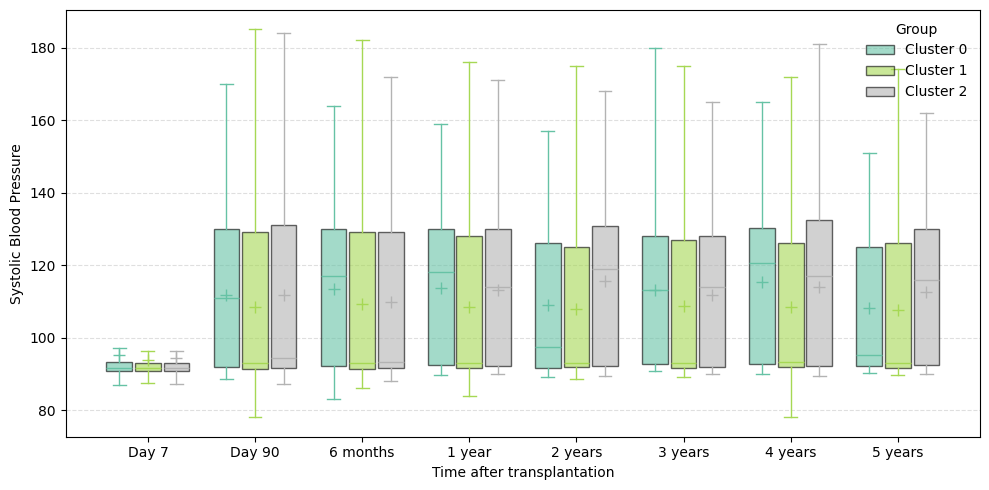

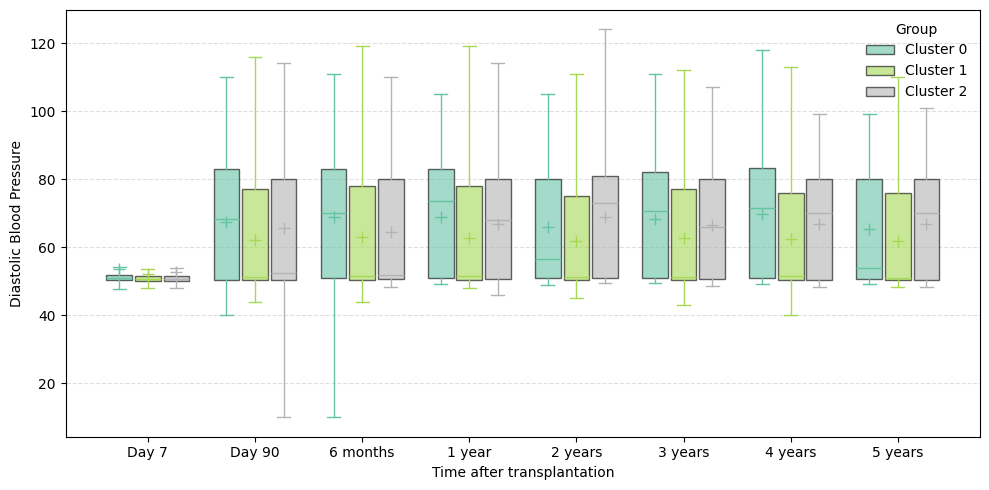

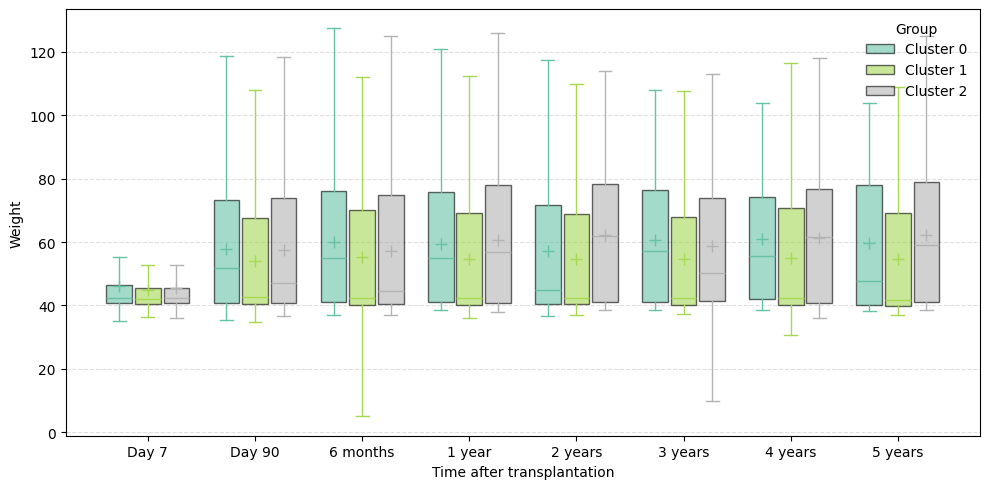

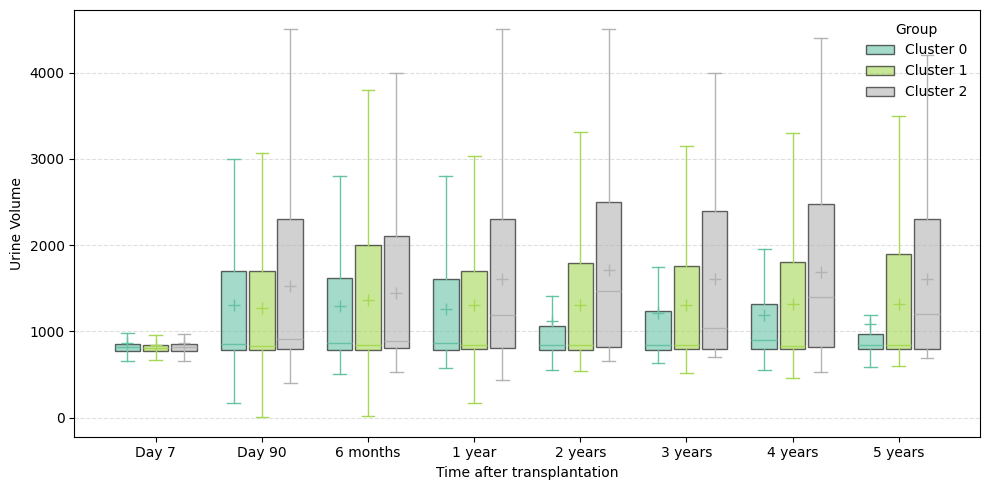

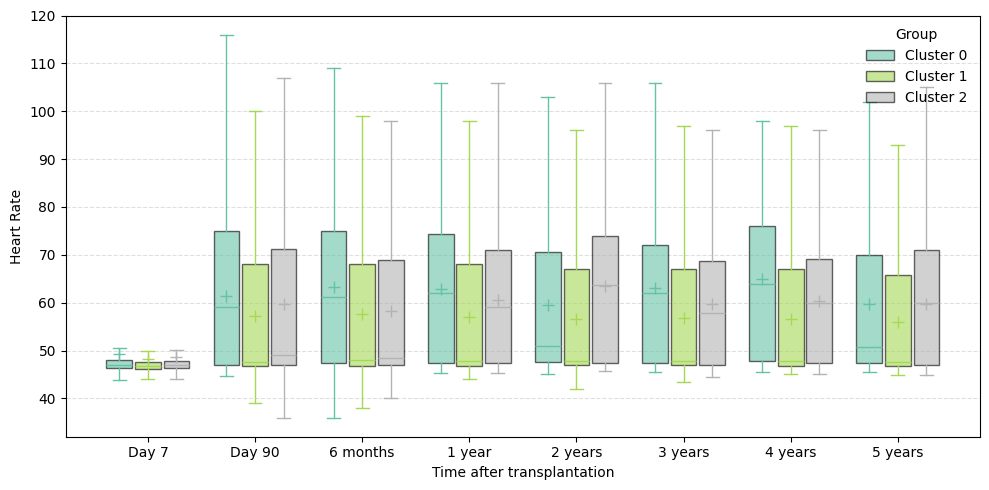

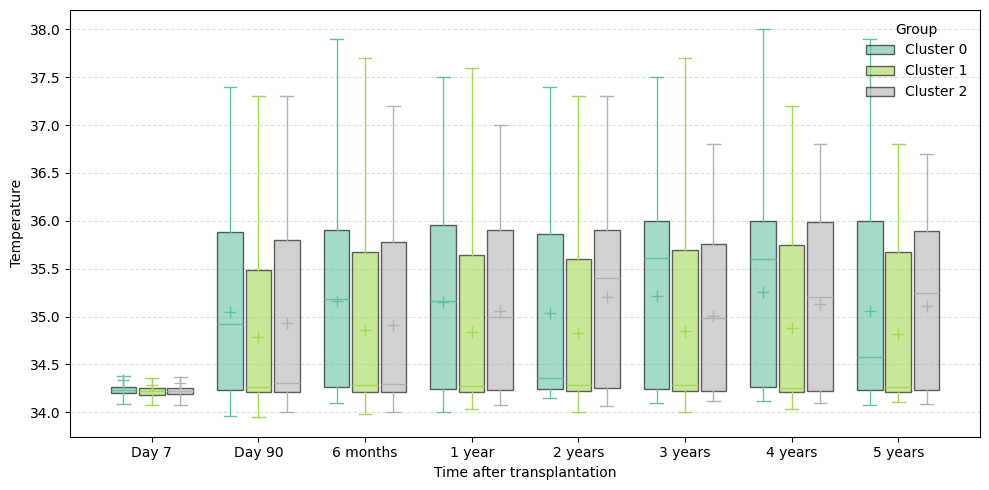

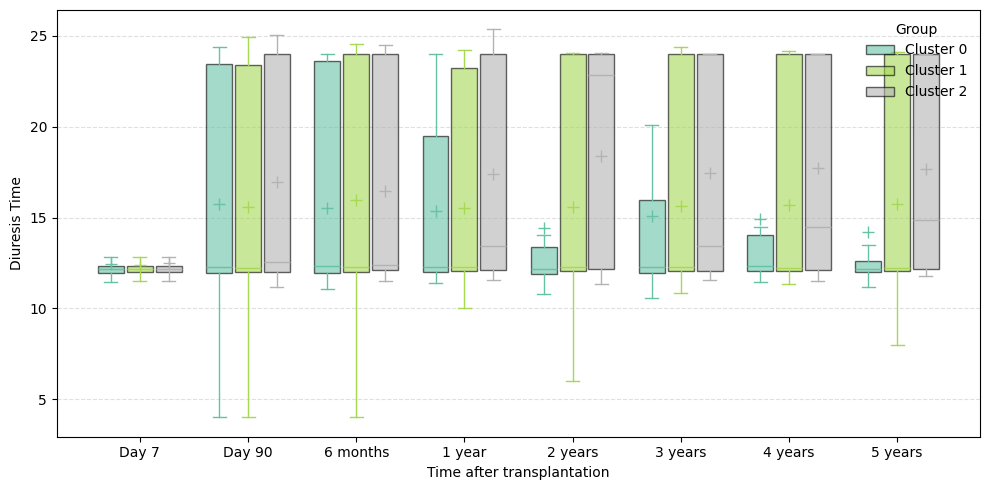

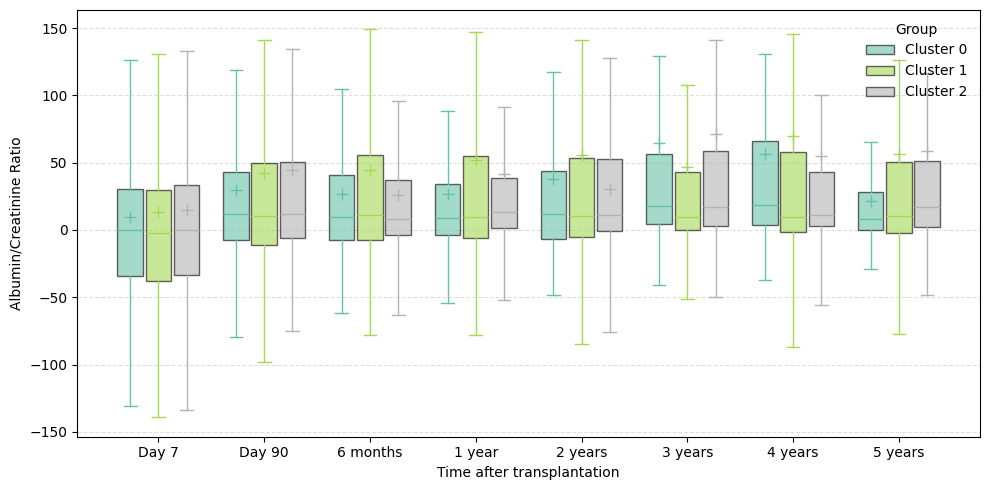

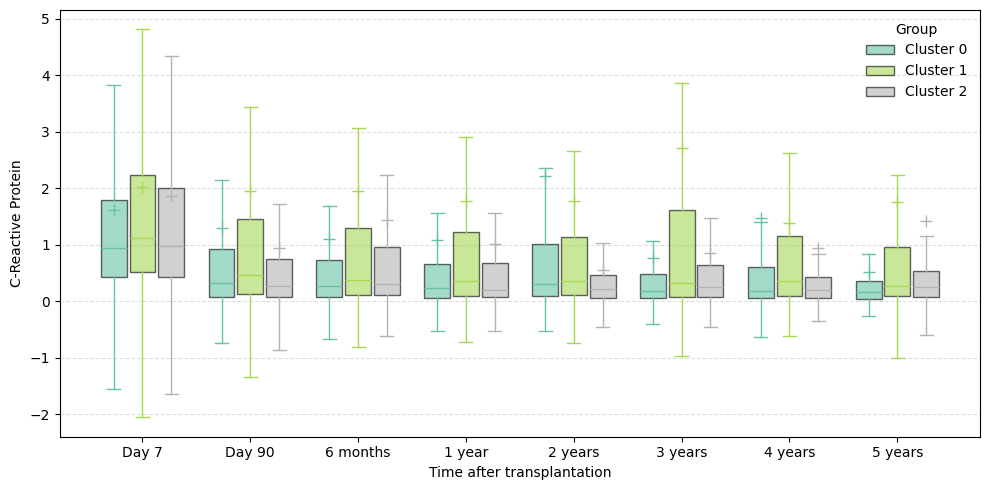

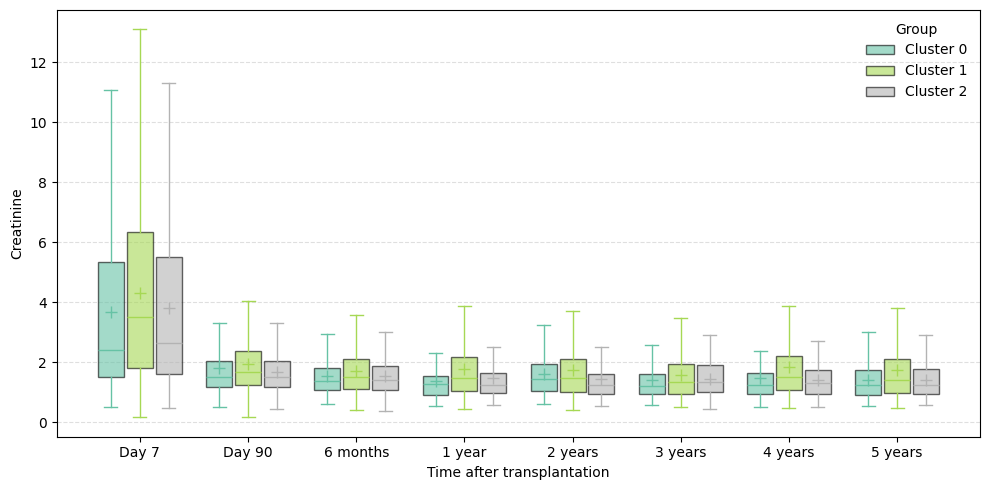

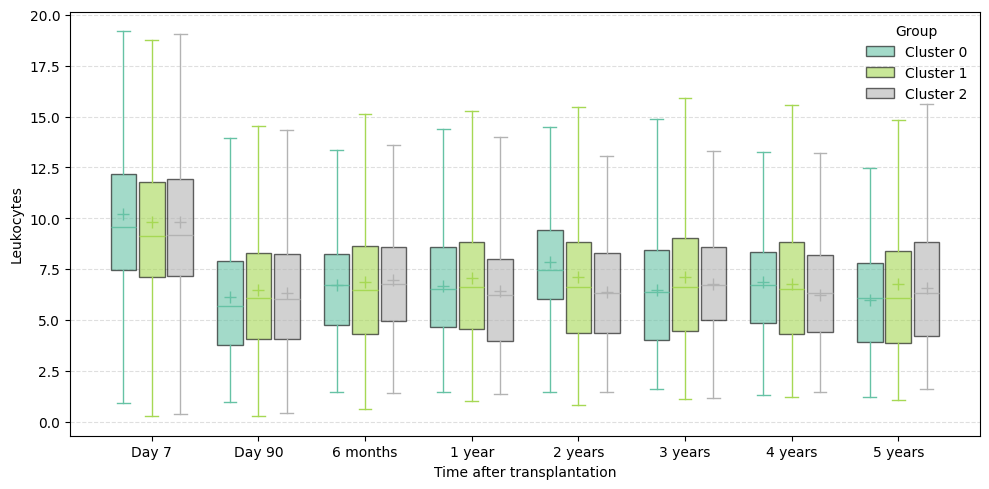

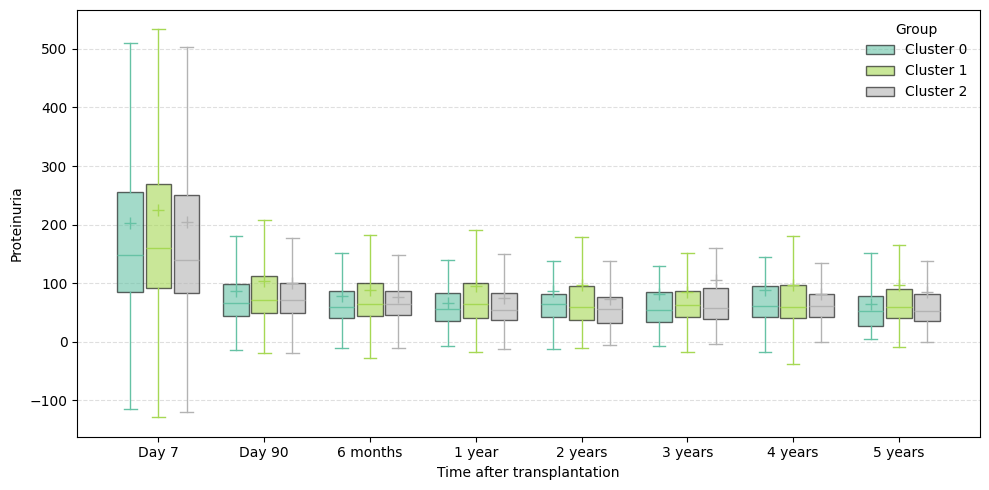

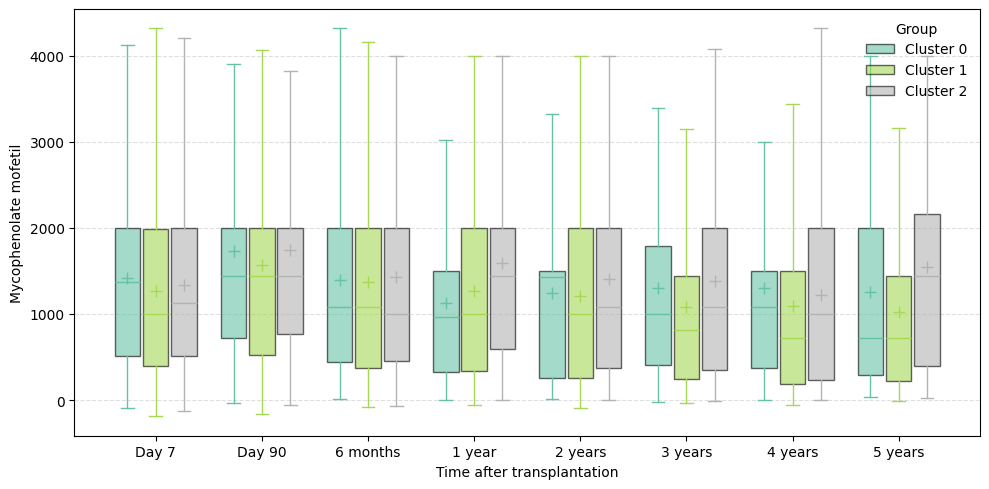

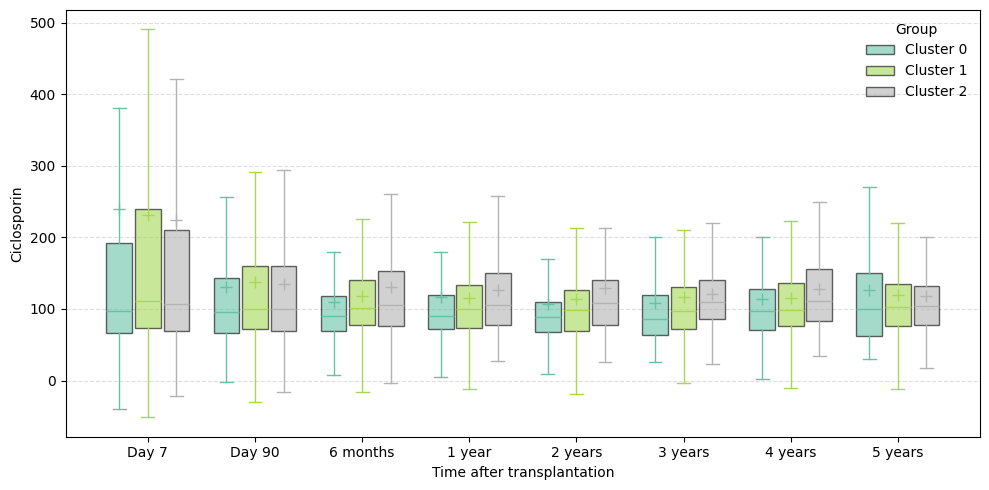

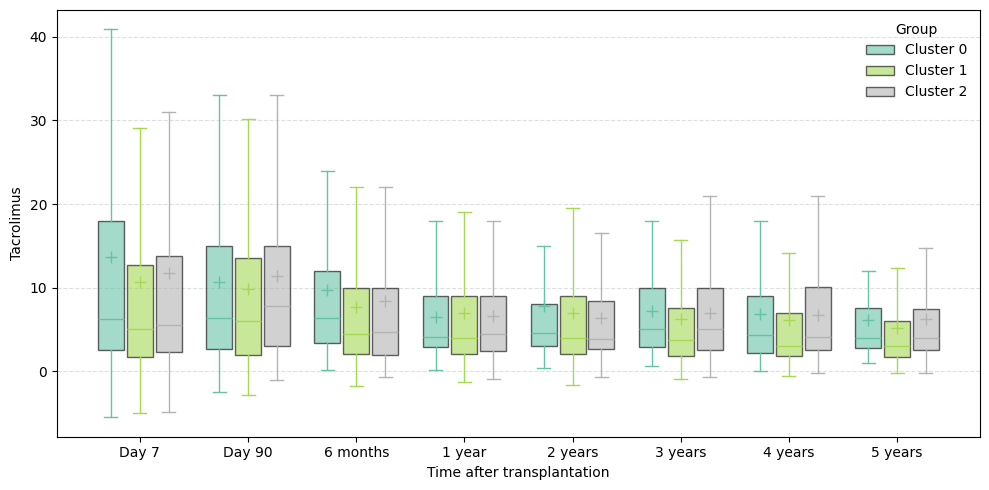

In [ ]:
# plot time series features boxplots
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import matplotlib.cm as cm

def plot_ts_feature_boxplots_by_time(
    real_ts_features_list,   
    rel_days_list,           
    groups,                  
    feature_names,           
    timepoints=(7, 90, 180, 365, 730, 1095),
    window=7,                
    group_names=None,
    show_means=True
):

    uniq_groups = np.array(sorted(np.unique(groups)))
    K = len(uniq_groups)
    if group_names is None:
        group_names = {g: f"Group {g}" for g in uniq_groups}

    # distinct color for each cluster
    cmap = cm.get_cmap("Set2", K)
    cluster_colors = {g: cmap(i) for i, g in enumerate(uniq_groups)}

    patients_by_group = {g: np.where(groups == g)[0] for g in uniq_groups}

    for f_idx, feat in enumerate(feature_names):
        bucket = defaultdict(list)

        for g in uniq_groups:
            for pid in patients_by_group[g]:
                y = real_ts_features_list[pid][:, f_idx]        
                t = rel_days_list[pid]                          
                if len(y) == 0: 
                    continue
                for tp in timepoints:
                    if tp < 100:
                        mask = (t >= (tp - window)) & (t <= (tp + window))
                    else:
                        mask = (t >= (tp - window + 100)) & (t <= (tp + window + 100))
                    if np.any(mask):
                        vals = y[mask]
                        vals = vals[~np.isnan(vals)]
                        if vals.size:
                            bucket[(tp, g)].extend(vals.tolist())

        fig, ax = plt.subplots(figsize=(10, 5))
        tp_positions = np.arange(len(timepoints))
        width = 0.8 / max(K, 1)  
        all_boxes = []

        for gi, g in enumerate(uniq_groups):
            xs = tp_positions + (gi - (K-1)/2) * width
            data_for_boxes = [bucket.get((tp, g), []) for tp in timepoints]

            b = ax.boxplot(
                data_for_boxes,
                positions=xs,
                widths=width*0.9,
                patch_artist=True,
                showfliers=False,
                whis=1.5
            )

            # Color the boxes by cluster
            for patch in b['boxes']:
                patch.set_facecolor(cluster_colors[g])
                patch.set_alpha(0.6)
            for cap in b['caps'] + b['whiskers'] + b['medians']:
                cap.set_linewidth(1.0)
                cap.set_color(cluster_colors[g])

            all_boxes.append((b, xs))

            if show_means:
                for x_pos, vals in zip(xs, data_for_boxes):
                    if len(vals):
                        ax.plot(x_pos, np.mean(vals), marker="+", markersize=8, color=cluster_colors[g])

        ax.set_xticks(tp_positions)
        ax.set_xticklabels([f"Day {tp}" if tp < 120 else
                            ("6 months" if tp == 180 else
                             f"{tp//365} year" + ("s" if tp//365 > 1 else "")) 
                            for tp in timepoints])

        ax.set_ylabel(feat)
        ax.set_xlabel("Time after transplantation")

        handles = [all_boxes[i][0]['boxes'][0] for i in range(K)]
        labels = [group_names.get(g, f"Group {g}") for g in uniq_groups]
        ax.legend(handles, labels, title="Group", loc="upper right", frameon=False)

        ax.grid(axis="y", linestyle="--", alpha=0.4)
        fig.tight_layout()
        #fig.savefig(Path(save_dir) / f"{feat.replace('/', '_')}_boxplot.png", dpi=200)
        #plt.close(fig)
        fig.show()

feature_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin',
    'underlying_disease': 'Underlying Disease',
    'type_of_donation': 'Type of Donation', 
    'blood_group': 'Recipient Blood Group',
    'ebv_status': 'EBV Status', 
    'delayed_graft_function': 'Delayed Graft Function',  
    'donor_bloodgroup': 'Donor Blood Group',
    'gender': 'Recipient Gender', 
    'gender_donor': 'Donor Gender',
    'number_dialyses': 'Number of Dialyses', 
    'age': 'Recipient Age', 
    'height': 'Recipient Height', 
    'cold_ischemia_time': 'Cold Ischemia Time',
    'age_donor': 'Donor Age', 
    'days_in_hospital': 'Days in Hospital', 
    'number_transplantation': 'Number of Transplantations',
    'pirche_score': 'PIRCHE Score', 
    'risk_of_graft_failure': 'Risk of Graft Failure',
    'bp_sys': 'Systolic Blood Pressure', 
    'bp_dia': 'Diastolic Blood Pressure', 
    'weight': 'Weight', 
    'urine_volume': 'Urine Volume', 
    'heart_rate': 'Heart Rate', 
    'temperature': 'Temperature', 
    'diuresis_time': 'Diuresis Time', 
    'albumin': 'Albumin/Creatinine Ratio', 
    'crphp': 'C-Reactive Protein',
    'creatinine': 'Creatinine', 
    'leukocyte': 'Leukocytes', 
    'proteinuria': 'Proteinuria', 
}


def map_feature_names(features, feature_map):
    """Replace codes with readable names if available."""
    return [feature_map.get(f, f) for f in features]

CONFIG_mapped = {}
for key, val in CONFIG.items():
    if isinstance(val, list):
        CONFIG_mapped[key] = map_feature_names(val, feature_map)
    else:
        CONFIG_mapped[key] = val


real_ts_features_list = real_ts_features_l     
rel_days_list= rel_days_l 
groups= spectral_labels
feature_names= CONFIG_mapped['ts_feat']    


plot_ts_feature_boxplots_by_time(     
     real_ts_features_list, rel_days_list, spectral_labels, feature_names,#    
     timepoints=(7, 90, 180, 365, 730, 1095, 1460, 1825), window=10,
     group_names={0:"Cluster 0", 1:"Cluster 1", 2:"Cluster 2"}, show_means=True
    )


In [ ]:
# kruskal and chi squared analysis on numerical and categorical features
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, chi2_contingency
from statsmodels.stats.multitest import multipletests
from cliffs_delta import cliffs_delta
from sklearn.preprocessing import StandardScaler
from itertools import combinations


PLOT = False


numerical_features = CONFIG['static_numerical_feat']
categorical_features = CONFIG['static_categorical_feat']

# Create DataFrames
num_df = pd.DataFrame(num_static_l, columns=numerical_features)
cat_df = pd.DataFrame(cat_static_l, columns=categorical_features)
meta_df = pd.DataFrame({'cluster': spectral_labels, 'weight': 1.0})  # Initial weight

df = pd.concat([meta_df, num_df, cat_df], axis=1)


cluster_sizes = df['cluster'].value_counts().sort_index()
total_size = cluster_sizes.sum()
weights = total_size / (3 * cluster_sizes)  # Equalize effective contribution
df['weight'] = df['cluster'].map(weights)

results = []

for feat in numerical_features:
    try:
        # Weighted Kruskal-Wallis test for multiple groups
        groups = [df[df['cluster'] == cluster][feat].dropna() for cluster in df['cluster'].unique()]
        weights_list = [df[df['cluster'] == cluster]['weight'].dropna() for cluster in df['cluster'].unique()]
        # scipy.stats.kruskal doesn't support weights directly; approximate with weighted means
        weighted_means = [np.average(g, weights=w) for g, w in zip(groups, weights_list)]
        stat, pval = kruskal(*groups)  # Use raw groups for now; consider custom weighted test if needed

        # Calculate median differences across all clusters (on normalized data)
        medians = [df[df['cluster'] == cluster][feat].median() for cluster in df['cluster'].unique()]
        median_diff = max(medians) - min(medians) if medians else None

        # Pairwise cliffs_delta for effect size (simplified average on normalized data)
        deltas = []
        for cluster_i, cluster_j in combinations(df['cluster'].unique(), 2):
            delta, _ = cliffs_delta(df[df['cluster'] == cluster_i][feat].dropna(),
                                  df[df['cluster'] == cluster_j][feat].dropna())
            deltas.append(abs(delta) if delta is not None else 0)
        effect_size = np.mean(deltas) if deltas else None

        if PLOT and pval is not None:
            plt.figure(figsize=(6, 4))
            sns.boxplot(data=df, x='cluster', y=feat, weights=df['weight'])
            plt.title(f'{feat} Across All Clusters (p={pval:.3f})')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        results.append({
            'feature': feat,
            'type': 'numerical',
            'statistic': stat,
            'p_value': pval,
            'cliffs_delta': effect_size,
            'median_diff': median_diff,
            'significant': pval < 0.05
        })
    except Exception as e:
        print(f"Error with {feat}: {e}")
        results.append({
            'feature': feat,
            'type': 'numerical',
            'statistic': None,
            'p_value': None,
            'cliffs_delta': None,
            'median_diff': None,
            'significant': False
        })

for feat in categorical_features:
    try:
        # Weighted Chi-square test (approximate by adjusting contingency table)
        contingency = pd.crosstab(df[feat], df['cluster'], values=df['weight'], aggfunc='sum')
        chi2, pval, dof, _ = chi2_contingency(contingency.fillna(0))

        if PLOT and pval is not None:
            plt.figure(figsize=(6, 4))
            sns.countplot(data=df, x='cluster', hue=feat, weights=df['weight'])
            plt.title(f'{feat} Across All Clusters (p={pval:.3f}, normalized)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        results.append({
            'feature': feat,
            'type': 'categorical',
            'statistic': chi2,
            'p_value': pval,
            'cliffs_delta': None,
            'median_diff': None,
            'significant': pval < 0.05
        })
    except Exception as e:
        print(f"Error with {feat}: {e}")
        results.append({
            'feature': feat,
            'type': 'categorical',
            'statistic': None,
            'p_value': None,
            'cliffs_delta': None,
            'median_diff': None,
            'significant': False
        })

# Adjust p-values for multiple comparisons
p_values = [r['p_value'] for r in results if r['p_value'] is not None]
if p_values:
    reject, pvals_adj, _, _ = multipletests(p_values, method='bonferroni')
    for i, result in enumerate(results):
        if result['p_value'] is not None:
            result['p_value_adj'] = pvals_adj[i]
            result['significant_adj'] = reject[i]

# Final Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['type', 'p_value'])

print("=== Global Feature Differences Across All Clusters ===")
print(results_df)


=== Global Feature Differences Across All Clusters ===
                   feature         type    statistic       p_value  \
14        type_of_donation  categorical   251.239233  4.564193e-43   
11              ebv_status  categorical   175.058537  8.582396e-37   
9       underlying_disease  categorical  1315.250704  1.384093e-20   
12  delayed_graft_function  categorical    87.910268  3.658535e-18   
10             blood_group  categorical    57.022205  1.647967e-06   
13        donor_bloodgroup  categorical    27.009584  4.137675e-02   
16            gender_donor  categorical     4.934255  2.941101e-01   
15                  gender  categorical     1.689970  4.295639e-01   
5         days_in_hospital    numerical   131.245888  3.164591e-29   
1                      age    numerical    99.880969  2.047025e-22   
3       cold_ischemia_time    numerical    62.145982  3.200158e-14   
4                age_donor    numerical    32.234888  1.000652e-07   
0          number_dialyses    numer

In [ ]:
# compare numerical features across clusters
from scipy.stats import mannwhitneyu
import pandas as pd
from itertools import combinations

# List of numerical features
numerical_features = CONFIG['static_numerical_feat']

# Prepare results
results = []

# Pairwise cluster combinations
cluster_pairs = list(combinations([0, 1, 2], 2))

for feature in numerical_features:
    for c1, c2 in cluster_pairs:
        group1 = df[df['cluster'] == c1][feature].dropna()
        group2 = df[df['cluster'] == c2][feature].dropna()
        
        # Skip if one group is empty
        if len(group1) == 0 or len(group2) == 0:
            continue  
        
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        results.append({
            'feature': feature,
            'cluster_1': c1,
            'cluster_2': c2,
            'U_statistic': stat,
            'p_value': p,
            'median_1': group1.median(),
            'median_2': group2.median(),
            'median_diff': group1.median() - group2.median(),
            'significant': p < 0.05
        })

# Convert to DataFrame
wmw_results = pd.DataFrame(results)

wmw_results.sort_values(by='p_value', inplace=True)

print("\n--- Mann-Whitney U Test Results ---")
print(wmw_results)


--- Mann-Whitney U Test Results ---
                   feature  cluster_1  cluster_2  U_statistic       p_value  \
3                      age          0          1     258605.5  9.218608e-21   
15        days_in_hospital          0          1     261275.0  6.365847e-20   
17        days_in_hospital          1          2     676213.5  3.708704e-16   
9       cold_ischemia_time          0          1     277070.0  2.541015e-15   
10      cold_ischemia_time          0          2      60647.5  3.690729e-08   
4                      age          0          2      60897.0  5.693377e-08   
14               age_donor          1          2     622006.0  2.151306e-06   
5                      age          1          2     618941.0  5.497749e-06   
2          number_dialyses          1          2     607058.5  4.176544e-05   
12               age_donor          0          1     330216.0  1.521723e-04   
6                   height          0          1     424013.0  4.727448e-04   
21            p

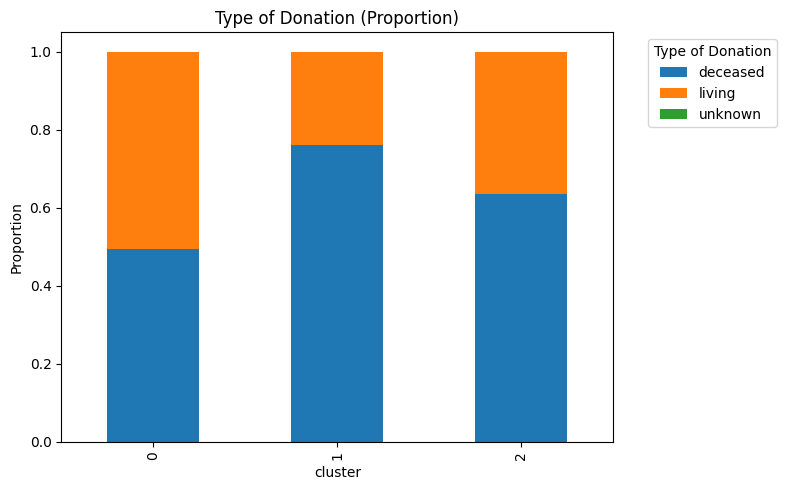

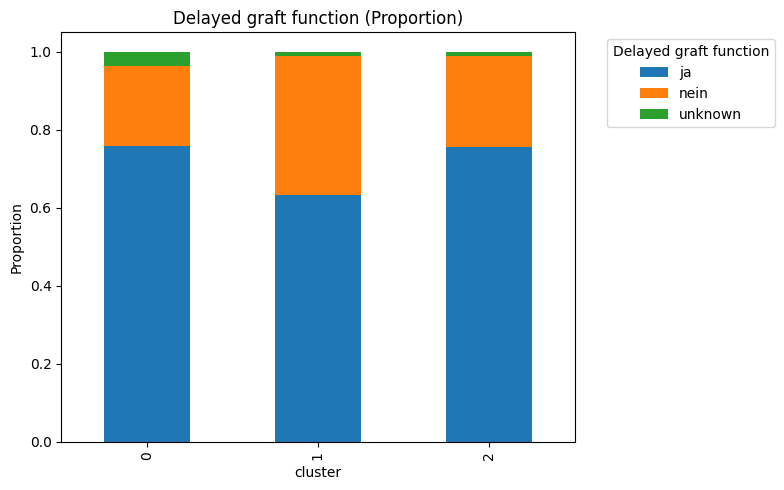

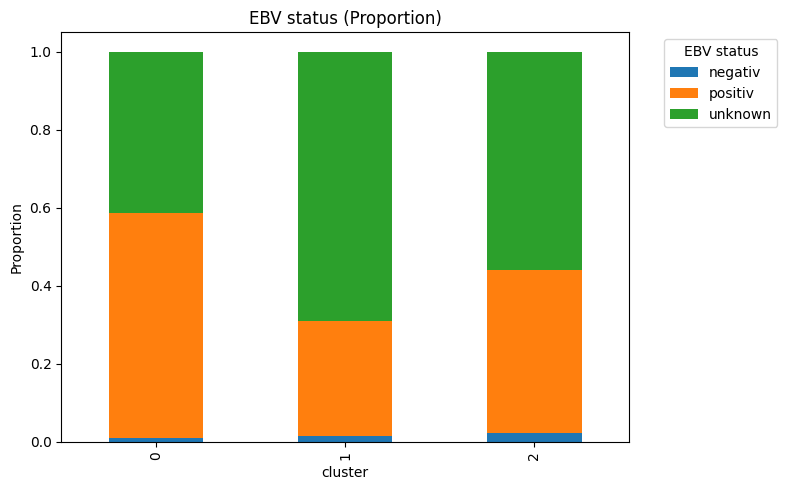

In [ ]:
# plot categorical distribution across clusters
def plot_categorical_feature(df, feature, cluster_col='cluster', normalize=True):
    # Define mapping from cluster number to risk group name
    # Get cross-tabulated counts or proportions
    ct = pd.crosstab(df[cluster_col], df[feature], normalize='index' if normalize else False)

    # Plot
    ct.plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f"{feature}" + (" (Proportion)" if normalize else " (Counts)"))
    plt.ylabel('Proportion' if normalize else 'Count')
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


df = pd.DataFrame({
    'cluster': spectral_labels,
    'Type of Donation': cat_static_l[:, 5] , # Assuming 'type_of_donation' is the first categorical feature
    'Delayed graft function': cat_static_l[:, 3],  # Assuming 'delayed_graft_function' is the second categorical feature
    'EBV status': cat_static_l[:, 2],  # Assuming 'ebv_status' is the third categorical feature
})
# Define the translation map
translation_map = {
    'hirntot': 'deceased',
    'lebend(andere verwandt)': 'living',
    'lebend(ehepartner)': 'living',
    'lebend(elternteil)': 'living',
    'lebend(geschwister)': 'living',
    'lebend(großeltern)': 'living',
    'lebend(kind)': 'living',
    'lebend(nicht verwandt)': 'living',
    'lebend(unbekannt)': 'living',
    'unknown': 'unknown'
}

# Apply the mapping to create a translated column
df['Type of Donation'] = df['Type of Donation'].map(translation_map).fillna(df['Type of Donation'])
 
plot_categorical_feature(df, 'Type of Donation', normalize=True)
plot_categorical_feature(df, 'Delayed graft function', normalize=True)
plot_categorical_feature(df, 'EBV status', normalize=True)



=== Kruskal–Wallis (FDR across features) ===
             feature            H              p          p_fdr
11      L04AD02_last  1053.956769  1.368345e-229  2.189352e-228
8    creatinine_last   900.583870  2.758655e-196  2.206924e-195
10      L04AD01_last   799.231633  2.812264e-174  1.499874e-173
9       L04AA06_last   357.905911   1.913017e-78   7.652069e-78
0    creatinine_mean    87.091564   1.225483e-19   3.921544e-19
4     creatinine_std    71.936551   2.394289e-16   6.384770e-16
14     L04AD01_slope    67.472067   2.231654e-15   5.100924e-15
1       L04AA06_mean    41.144712   1.162892e-09   2.325783e-09
12  creatinine_slope    36.156209   1.408572e-08   2.504128e-08
3       L04AD02_mean    29.121896   4.745267e-07   7.592426e-07
5        L04AA06_std    18.611603   9.089538e-05   1.322115e-04
15     L04AD02_slope    15.558761   4.182713e-04   5.576951e-04
2       L04AD01_mean    15.129991   5.182797e-04   6.378827e-04
7        L04AD02_std    11.722455   2.847745e-03   3.25456

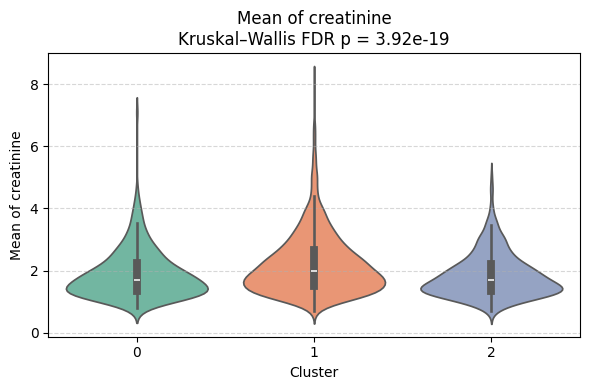

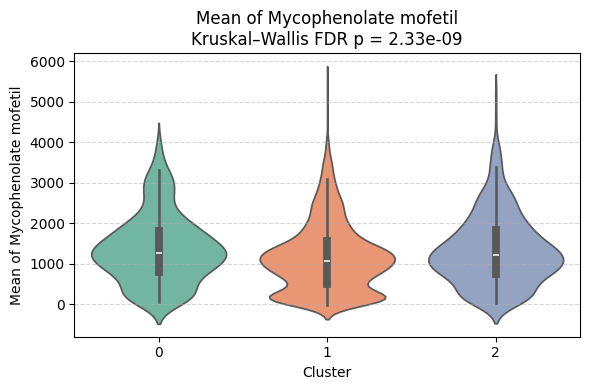

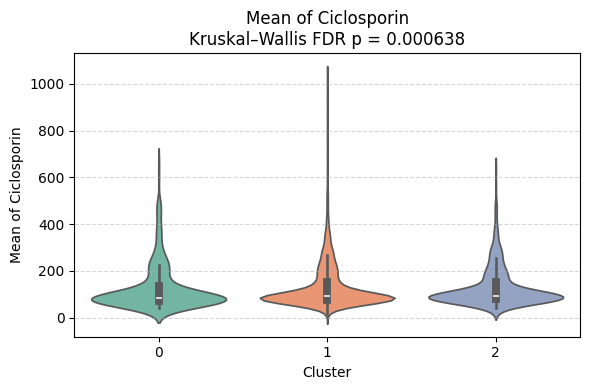

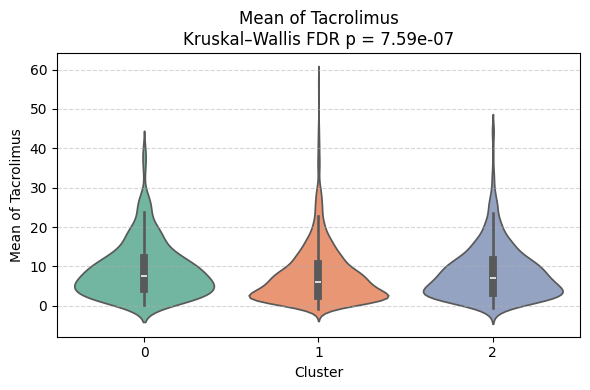

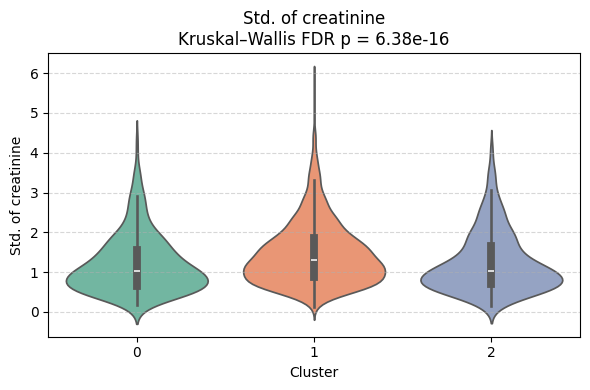

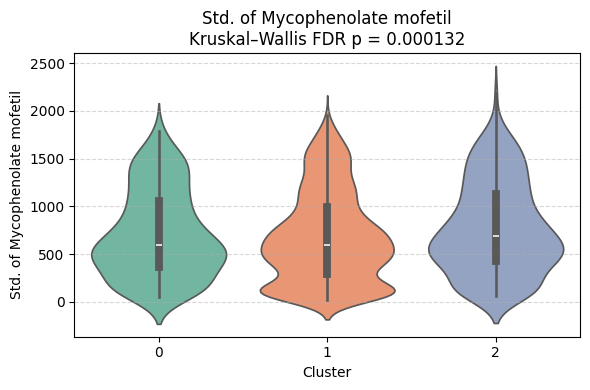

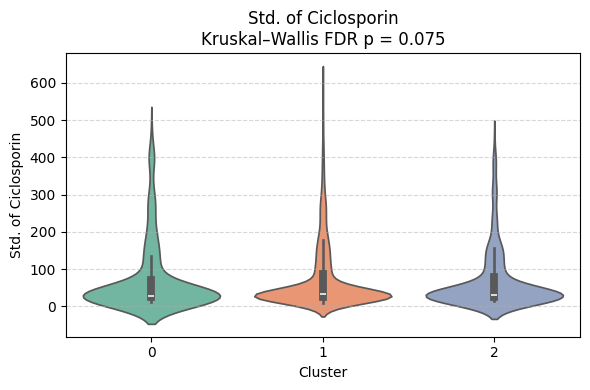

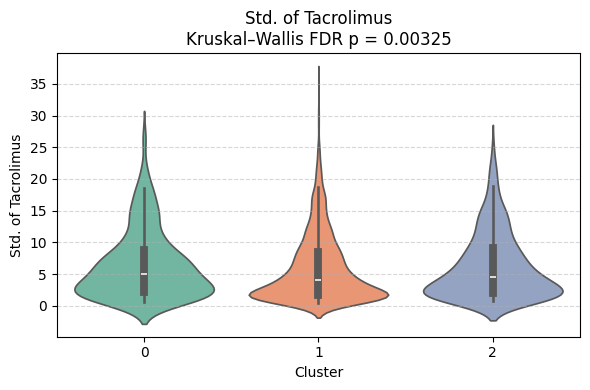

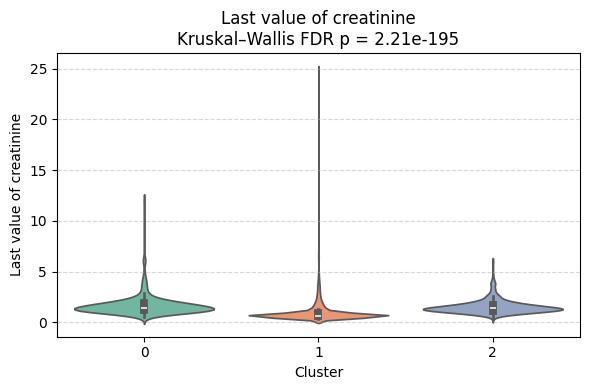

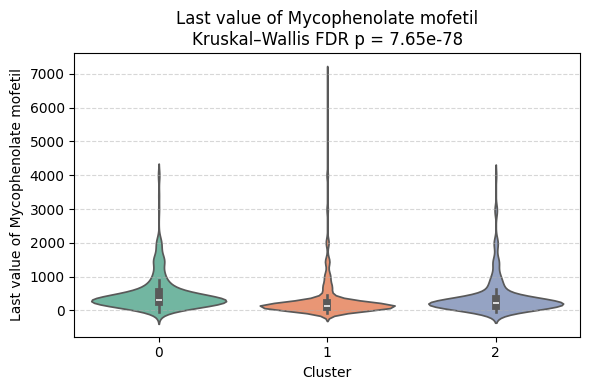

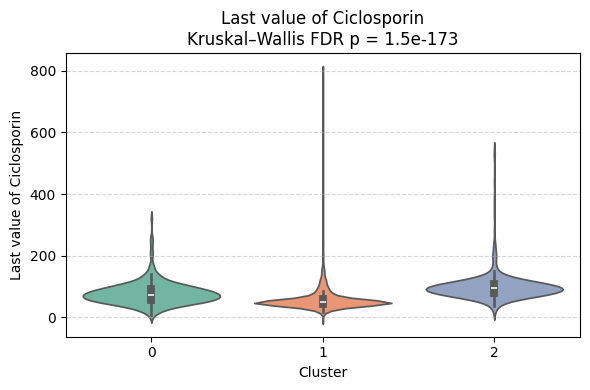

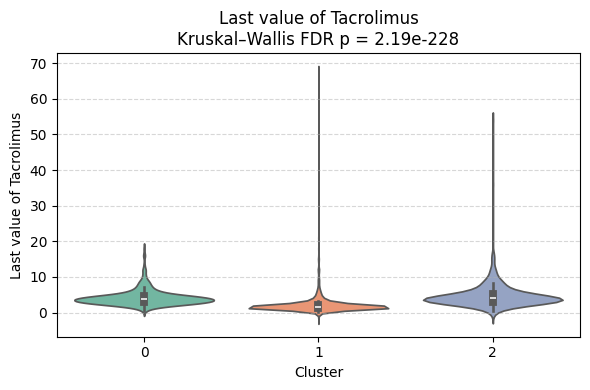

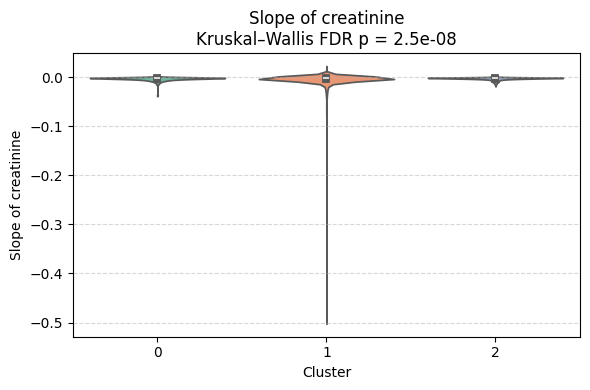

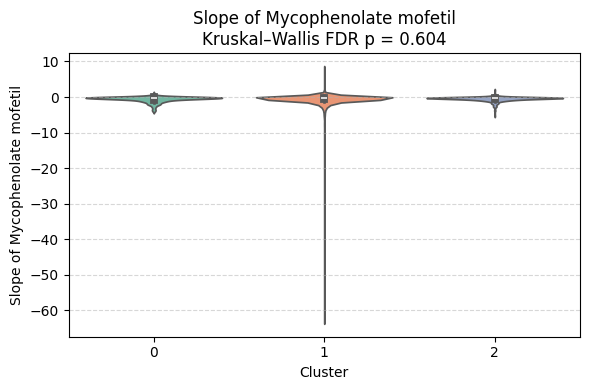

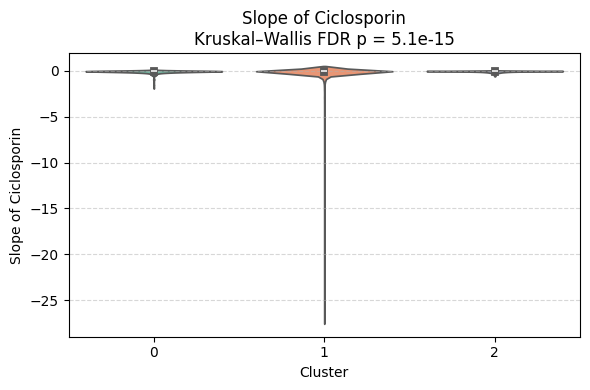

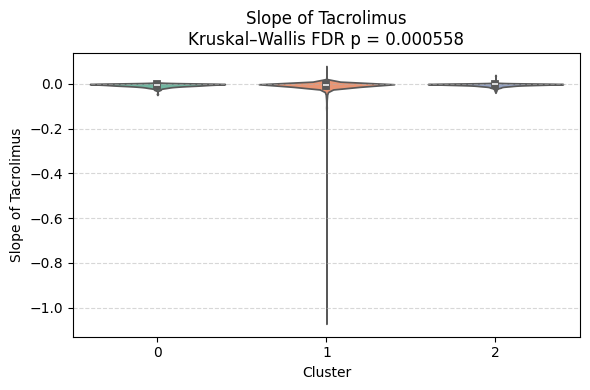

In [ ]:
# plot creatinine and medication: mean, std, last, slope
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

atc_name_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin'
}

def format_feature_label(feature_name):
    stat_map = {
        'mean': 'Mean of',
        'std': 'Std. of',
        'last': 'Last value of',
        'slope': 'Slope of'
    }
    parts = feature_name.split('_')
    if len(parts) >= 2:
        stat = parts[-1]
        var = '_'.join(parts[:-1])
        label_var = atc_name_map.get(var, var)  # fallback method if not found
        return f"{stat_map.get(stat, stat)} {label_var}"
    return feature_name

# key features to visualize
base_feats = CONFIG['ts_feat']
feature_names = (
    [f"{f}_mean" for f in base_feats] +
    [f"{f}_std" for f in base_feats] +
    [f"{f}_last" for f in base_feats] +
    [f"{f}_slope" for f in base_feats]
)

ts_feats_l_ = np.stack(ts_feats_l, axis=0)
# Convert ts_feats_l_ to DataFrame
df_features = pd.DataFrame(ts_feats_l_, columns=feature_names)
df_features["cluster"] = spectral_labels

# create selected features : every feature starts with creatinine and L
selected_features = [f for f in feature_names if f.startswith('creatinine') or f.startswith('L')]

import itertools
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

alpha = 0.05  # significance level

clusters = sorted(df_features["cluster"].unique())

# Global (per-feature) Kruskal across clusters
kruskal_rows = []
for feature in selected_features:
    groups = [df_features.loc[df_features.cluster == c, feature].dropna() for c in clusters]
    # Skip if any group is empty
    if any(len(g) == 0 for g in groups):
        H, p = np.nan, np.nan
    else:
        H, p = kruskal(*groups)
    kruskal_rows.append({"feature": feature, "H": H, "p": p})

kruskal_df = pd.DataFrame(kruskal_rows)
# FDR across all features
_, p_adj_all, _, _ = multipletests(kruskal_df["p"].values, method="fdr_bh")
kruskal_df["p_fdr"] = p_adj_all
kruskal_df.sort_values("p_fdr", inplace=True)
print("\n=== Kruskal–Wallis (FDR across features) ===")
print(kruskal_df[["feature", "H", "p", "p_fdr"]])

# Helper: quick lookup for plot titles
p_fdr_map = dict(zip(kruskal_df["feature"], kruskal_df["p_fdr"]))

# Pairwise Mann–Whitney for significant features (per-feature FDR)
pairwise_results = []
for feature in kruskal_df.loc[kruskal_df["p_fdr"] < alpha, "feature"]:
    pairs = list(itertools.combinations(clusters, 2))
    pvals = []
    stats = []
    for (c1, c2) in pairs:
        x = df_features.loc[df_features.cluster == c1, feature].dropna()
        y = df_features.loc[df_features.cluster == c2, feature].dropna()
        if len(x) == 0 or len(y) == 0:
            U, p = np.nan, np.nan
        else:
            try:
                U, p = mannwhitneyu(x, y, alternative="two-sided", method="auto")
            except TypeError:
                U, p = mannwhitneyu(x, y, alternative="two-sided")
        stats.append(U); pvals.append(p)

    # FDR within this feature's pairwise tests
    _, p_adj_pair, _, _ = multipletests(pvals, method="fdr_bh")
    for (c1, c2), U, p_raw, p_adj in zip(pairs, stats, pvals, p_adj_pair):
        pairwise_results.append({
            "feature": feature,
            "cluster1": c1,
            "cluster2": c2,
            "U": U,
            "p_pair": p_raw,
            "p_pair_fdr": p_adj
        })

pairwise_df = pd.DataFrame(pairwise_results)
if not pairwise_df.empty:
    pairwise_df = pairwise_df.sort_values(["feature", "p_pair_fdr"])
    print("\n=== Pairwise Mann–Whitney (per-feature FDR) ===")
    print(pairwise_df)

# Plots with Kruskal FDR p in the title
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df_features, x="cluster", y=feature, inner="box", palette="Set2")
    plt.xlabel("Cluster")
    plt.ylabel(format_feature_label(feature))

    pf = p_fdr_map.get(feature, np.nan)
    title = f"{format_feature_label(feature)}\nKruskal–Wallis FDR p = {pf:.3g}" if pd.notna(pf) else format_feature_label(feature)
    plt.title(title)

    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
